JM: 06 Jun 23

Analysis of the Eady system with a small slope. Mostly focusing on $l=0$ case.

* NOTE: $l=0$ and $l>0$ cases seem quite different. While it is true that $l=0$ cases are general most unstable, $l>0$ cases allow more instabilities at the lower wavenumbers it seems (some argument about reducing the phase speed with $l>0$ probably)

In [1]:
# prelim loading

import numpy as np
import matplotlib.pyplot as plt

from numba import jit
import copy
from scipy.optimize import fsolve

from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import make_axes
import matplotlib.ticker as mticker

# define some defaults
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["mathtext.rm"] = "serif"
plt.rcParams["image.cmap"] = "RdBu_r" # \"*_r\" is reverse of standard colour\n",
plt.rcParams["axes.formatter.limits"] = [-4, 4]
plt.rcParams["font.size"] = 12.0

label_str = "abcdefghijklmnopqrstuvwxyz"

-----
## 1) growth rate curves from dispersion relation

Note: the values of $c$ and $k$ will differ by a factor of 2 because of choice of non-dimensionalisation; growth rate $kc_i$ is invariant here because $c$ is larger by a factor of 2, but $k$ is smaller by a factor of 2 also. Has been checked and compared with dispersion relation from "standard" formulation.

In [2]:
# set up the various numerical values

zi = 1j

# Eady dispersion relation
def modified_eady(k, delta, l=0.0, Bu=1.0):

    mu = Bu * np.sqrt(k**2 + l**2)

    # coefficients of the quadratic
    a = 1.0
    b = delta / (2.0 * mu) * (np.tanh(mu) + 1.0 / np.tanh(mu))
    c = (delta / (2.0 * mu)) ** 2 - (
                                        ( (1.0 - delta / 2.0) / mu - 1.0 / np.tanh(mu) ) 
                                      * ( (1.0 - delta / 2.0) / mu - np.tanh(mu) )
                                    )
    
    # np.sqrt hates negative numbers (could use cmath.sqrt if needed)
    if b**2 - 4.0*a*c >= 0:
        c_p = ( -b + np.sqrt(b**2 - 4.0*a*c) ) / (2.0 * a)
        c_m = ( -b - np.sqrt(b**2 - 4.0*a*c) ) / (2.0 * a)
    else:
        c_p = ( -b + zi * np.sqrt(4.0*a*c - b**2) ) / (2.0 * a)
        c_m = ( -b - zi * np.sqrt(4.0*a*c - b**2) ) / (2.0 * a)
        
    return c_p, c_m

# compute marginal k_c: find last index of non-zero growth, average the k value
def find_kc(k_vec, c):
    last_ind = np.where((np.imag(c) > 0))[0][-1]
    return 0.5 * (k_vec[last_ind] + k_vec[last_ind+1])

# compute max k: find index corresponding to largest growth
def find_kmax(k_vec, growth):
    max_ind = np.where(growth == np.max(growth))[0][0]
    return k_vec[max_ind]

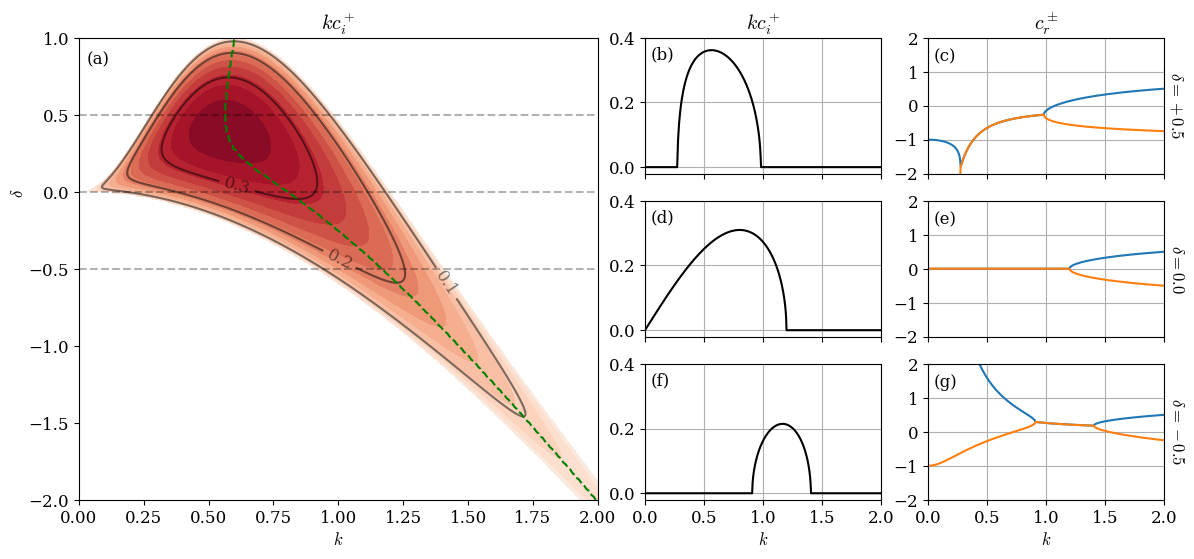

In [3]:
# general characteristics (l = 0)

delta_vec = np.linspace(-2, 1, 301)
k_vec = np.linspace(1e-3, 2, 501)

c_p = np.zeros((len(k_vec), len(delta_vec)), dtype=complex)
c_m = np.zeros((len(k_vec), len(delta_vec)), dtype=complex)

for i in range(len(k_vec)):
    for j in range(len(delta_vec)):
        c_p[i, j], c_m[i, j] = modified_eady(k_vec[i], delta_vec[j], l=0.0)  # l=0 and l>0 are quite different...

# compute other useful quantities
growth = k_vec[:, np.newaxis] * np.imag(c_p)
k_c = np.zeros(len(delta_vec))
k_max = np.zeros(len(delta_vec))
for j in range(len(delta_vec)):
#     k_c[j] = find_kc(k_vec, c_p[:, j])
    k_max[j] = find_kmax(k_vec, growth[:, j])

fig = plt.figure(figsize=(14, 6))

ax = plt.subplot2grid((3, 4), (0, 0), rowspan=3, colspan=2)
growth_dum = np.zeros(growth.shape)
growth_dum[:] = growth[:]
growth_dum[growth==0.0] = np.nan
ax.contourf(k_vec, delta_vec, growth_dum.T, levels=np.linspace(-0.4, 0.4, 31), cmap="RdBu_r")
lines = ax.contour(k_vec, delta_vec, growth_dum.T, levels=np.arange(0, 0.5, 0.1), colors="k", alpha=0.5)
ax.clabel(lines, inline=1, colors='k')
ax.plot([0, 2], [0.5, 0.5], 'k--', alpha=0.3)
ax.plot([0, 2], [0, 0], 'k--', alpha=0.3)
ax.plot([0, 2], [-0.5, -0.5], 'k--', alpha=0.3)
k_max[-1] = np.nan
plt.plot(k_max, delta_vec, 'g--')
ax.set_xlim((0, 2))
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\delta$")
ax.yaxis.set_label_coords(-0.1, 0.665)
ax.set_title(r"$kc^+_i$")
ax.text(0.03, 0.83, r"(a)")

delta_neg_ind = np.where(delta_vec==-0.5)[0][0]
delta_zero_ind = np.where(delta_vec==0)[0][0]
delta_pos_ind = np.where(delta_vec==+0.5)[0][0]

ax = plt.subplot2grid((3, 4), (0, 2))
ax.plot(k_vec, growth[:, delta_pos_ind], "k", label=r"$kc_{+,i}$")
ax.set_xlim((0, 2))
ax.set_ylim((-0.02, 0.4))
ax.set_xticklabels([])
ax.set_title(r"$kc^+_i$")
ax.grid()
ax.text(0.05, 0.335, r"(b)")
ax = plt.subplot2grid((3, 4), (1, 2))
ax.plot(k_vec, growth[:, delta_zero_ind], "k", label=r"$kc_{+,i}$")
ax.set_xlim((0, 2))
ax.set_ylim((-0.02, 0.4))
ax.set_xticklabels([])
ax.grid()
ax.text(0.05, 0.335, r"(d)")
ax = plt.subplot2grid((3, 4), (2, 2))
ax.plot(k_vec, growth[:, delta_neg_ind], "k", label=r"$kc_{+,i}$")
ax.set_xlim((0, 2))
ax.set_ylim((-0.02, 0.4))
ax.set_xlabel(r"$k$")
ax.grid()
ax.text(0.05, 0.335, r"(f)")

ax = plt.subplot2grid((3, 4), (0, 3))
ax.plot(k_vec, np.real(c_p[:, delta_pos_ind]), "C0", label=r"$c_{+,r}$")
ax.plot(k_vec, np.real(c_m[:, delta_pos_ind]), "C1", label=r"$c_{-,r}$")
ax.set_xlim((0, 2))
ax.set_ylim((-2, 2))
ax.set_xticklabels([])
ax.yaxis.set_label_position("right")
ax.set_ylabel(r"$\delta = +0.5$", rotation=-90, labelpad=15)
ax.set_title(r"$c_r^\pm$")
ax.grid()
ax.text(0.05, 1.32, r"(c)")
ax = plt.subplot2grid((3, 4), (1, 3))
ax.plot(k_vec, np.real(c_p[:, delta_zero_ind]), "C0", label=r"$c_{+,r}$")
ax.plot(k_vec, np.real(c_m[:, delta_zero_ind]), "C1", label=r"$c_{-,r}$")
ax.set_xlim((0, 2))
ax.set_ylim((-2, 2))
ax.set_xticklabels([])
ax.yaxis.set_label_position("right")
ax.set_ylabel(r"$\delta = 0.0$", rotation=-90, labelpad=15)
ax.grid()
ax.text(0.05, 1.32, r"(e)")
ax = plt.subplot2grid((3, 4), (2, 3))
ax.plot(k_vec, np.real(c_p[:, delta_neg_ind]), "C0", label=r"$c_{+,r}$")
ax.plot(k_vec, np.real(c_m[:, delta_neg_ind]), "C1", label=r"$c_{-,r}$")
ax.set_xlim((0, 2))
ax.set_ylim((-2, 2))
ax.set_xlabel(r"$k$")
ax.yaxis.set_label_position("right")
ax.set_ylabel(r"$\delta = -0.5$", rotation=-90, labelpad=15)
ax.grid()
ax.text(0.05, 1.32, r"(g)")

plt.savefig("./growth_rates_cr_l00.pdf", bbox_inches="tight")

-----
## 2) edge waves ans dynamical system

For $\gamma = \arctan(T/B)$ and $\Delta \epsilon = \epsilon_T - \epsilon_B$ (shifted by $\pi$ to translate from $b$ wave to $\psi$ or $q$ wave),

\begin{equation}
    \frac{\partial \gamma}{\partial t} = \frac{k}{\mu \sinh2\mu} \sin\Delta \epsilon (\cos 2\gamma + \delta \sin^2\gamma),
\end{equation}
\begin{equation}
    \frac{\partial \Delta\epsilon}{\partial t} = \frac{2k}{\mu \sinh2\mu} \left[\left(1-\frac{\delta}{2}\right)\cosh2\mu - \mu\sinh2\mu + \left(\frac{1}{\sin 2\gamma} - \frac{\delta}{2}\tan\gamma\right)\cos\Delta\epsilon \right]
\end{equation}

In [4]:
# subroutines

def dF(points, k, delta, l=0.0, Bu=1.0):
    """Generate the RHS of the dynamical system"""
    
    mu = Bu * np.sqrt(k**2 + l**2)
    deps, gamma = points
    
    eps_dot = 2.0 * k / (mu * np.sinh(2.0*mu)) * ( 
          (1.0 - 0.5*delta) * np.cosh(2.0*mu)
        -  mu * np.sinh(2.0*mu)
#         + 0.5 * (1.0 / np.tan(gamma) + (1.0 - delta)*np.tan(gamma)) * np.cos(deps)
        + (1.0 / np.sin(2.0*gamma) - 0.5*delta*np.tan(gamma)) * np.cos(deps)
    )
    gamma_dot = k / (mu * np.sinh(2.0*mu)) * np.sin(deps) * (np.cos(2.0*gamma) + delta * np.sin(gamma)**2)
    
    return eps_dot, gamma_dot

def dF_DB94(points, k, delta, l=0.0, Bu=1.0):
    """Generate the RHS of the dynamical system"""
    
    mu = Bu * np.sqrt(k**2 + l**2)
    deps, gamma = points
    
    eps_dot = 2.0 * k / (mu * np.sinh(mu)) * ( 
          np.cosh(mu) - 0.5*mu*np.sinh(mu) 
        - 1.0 / np.sin(2.0*gamma) * np.cos(deps)
    )
    gamma_dot = -k / (mu * np.sinh(mu)) * np.sin(deps) * np.cos(2.0*gamma)
    
    return eps_dot, gamma_dot

def get_root(dF, k, delta, guess_init=[0.5*np.pi, 0.25*np.pi], l=0.0, Bu=1.0):
    return fsolve(dF, guess_init, args = (k, delta, l, Bu))

def calc_growth_edge(k, delta, guess_init=[0.5*np.pi, 0.25*np.pi], l=0.0, Bu=1.0):
    
    mu = Bu * np.sqrt(k**2 + l**2)

    pos_root = get_root(dF, k, delta, guess_init=guess_init)  # (deps, gamma)
    
    # kill calculation if eps and/or gamma indicates we have neutral mode
    if (abs(pos_root[0]) < 1e-6) | (abs(abs(pos_root[0]) - np.pi) < 1e-6):
        print(f"phase difference small, calling it a neutral mode")
        growth_1 = growth_2 = 0
    else:
        growth_1 = (k / (mu * np.sinh(2.0*mu))) * (1.0 / np.tan(pos_root[1])) * np.sin(pos_root[0])
        growth_2 = (k * (1.0 - delta)  / (mu * np.sinh(2.0*mu))) * ( np.tan(pos_root[1])) * np.sin(pos_root[0])
    
    return growth_1, growth_2

def calc_psi_edge_2d(z_vec, x_vec, k, delta, gamma, deps, l=0.0, Bu=1.0):
    """Given deps and gamma calculate the implied streamfunction (note a shift in pi)"""

    mu = Bu * np.sqrt(k**2 + l**2)

    # by default set B = 1 and eps_B = 0, so T = tan(gamma) and eps_T = deps (note the shift in pi)
    T = np.tan(gamma)
    deps -= np.pi

    psi = np.zeros((len(z_vec), len(x_vec)))

    for i in range(len(z_vec)):
        psi[i, :] = np.real(1.0 / (mu * np.sinh(2.0 * mu)) * np.exp(zi * k * x_vec) *
                            (T * np.exp(zi * deps) * np.cosh(mu * (1.0 + z_vec[i])) 
                            -                        np.cosh(mu * (1.0 - z_vec[i]))
                            )
                            )
        
    # consider creating v and others too
        
    return psi

def calc_phase_shift(x_vec, k, field):
    
    ind_max_b = np.where(field[0, :] == np.max(field[0, :]))[0][0]
    ind_max_t = np.where(field[-1, :] == np.max(field[-1, :]))[0][0]
    
    return (x_vec[ind_max_b] - x_vec[ind_max_t]) / (2.0*np.pi / k) # in units of 2*pi (so 0.25 = np.pi/2)

def dgamma(gamma, delta):
    return np.cos(2.0*gamma) + delta*np.sin(gamma)**2

def get_root1(k, delta, guess_init=[0.5*np.pi, 0.25*np.pi], l=0.0, Bu=1.0):
    
    mu = Bu * np.sqrt(k**2 + l**2)
    
    gamma = fsolve(dgamma, guess_init[1], args = delta)[0]
    
    deps = np.arccos(
      - ( (1.0 - 0.5*delta) * np.cosh(2.0*mu) -  mu * np.sinh(2.0*mu) )
      / ( 1.0 / np.sin(2.0*gamma) - 0.5*delta*np.tan(gamma) )
#         + 0.5 * (1.0 / np.tan(gamma) + (1.0 - delta)*np.tan(gamma)) * np.cos(deps)
    )
    
    return (deps, gamma)

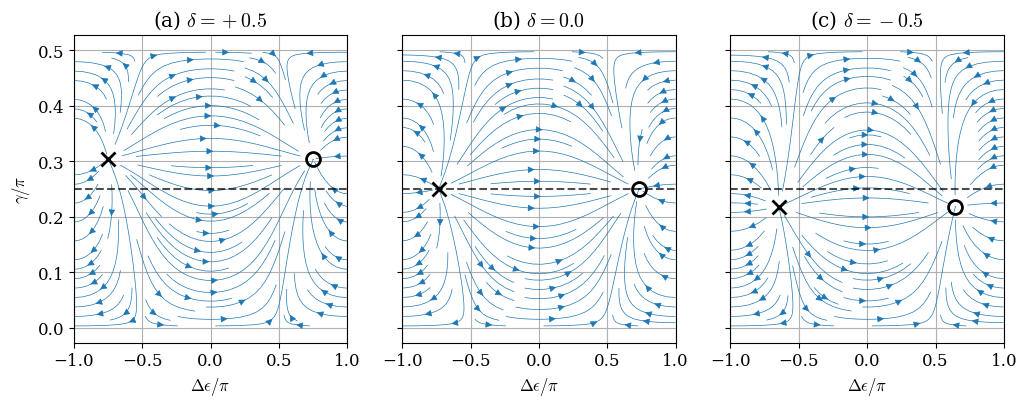

In [5]:
# phase portraits

deps, gamma = np.meshgrid(np.linspace(-np.pi, np.pi, 101), np.linspace(0.01, np.pi/2.0-0.01, 101))

points = np.asarray([deps, gamma])

fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 3, 1)
k = k_max[delta_pos_ind]
delta = 0.5
eps_dot, gamma_dot = dF(points, k, delta, l=0.0, Bu=1.0)
ax.streamplot(deps / np.pi, gamma / np.pi, eps_dot, gamma_dot, linewidth=0.5)
ax.plot([-1.0, 1.0], [0.25, 0.25], 'k--', alpha=0.7)
pos_root = get_root(dF, k, delta, guess_init=[0.25*np.pi, 0.25*np.pi])
neg_root = get_root(dF, k, delta, guess_init=[-0.25*np.pi, 0.25*np.pi])
ax.plot(pos_root[0] / np.pi, pos_root[1] / np.pi, 'ko', markersize=10, markerfacecolor='none', markeredgewidth=2)
ax.plot(neg_root[0] / np.pi, neg_root[1] / np.pi, 'kx', markersize=10, markerfacecolor='none', markeredgewidth=2)
ax.set_xlabel(r"$\Delta\epsilon / \pi$")
ax.set_ylabel(r"$\gamma / \pi$")
ax.set_title(r"(a) $\delta = +0.5$")
ax.grid()

ax = plt.subplot(1, 3, 2)
k = k_max[delta_zero_ind]
delta = 0.0
eps_dot, gamma_dot = dF(points, k, delta, l=0.0, Bu=1.0)
ax.streamplot(deps / np.pi, gamma / np.pi, eps_dot, gamma_dot, linewidth=0.5)
ax.plot([-1.0, 1.0], [0.25, 0.25], 'k--', alpha=0.7)
pos_root = get_root(dF, k, delta, guess_init=[0.25*np.pi, 0.25*np.pi])
neg_root = get_root(dF, k, delta, guess_init=[-0.25*np.pi, 0.25*np.pi])
ax.plot(pos_root[0] / np.pi, pos_root[1] / np.pi, 'ko', markersize=10, markerfacecolor='none', markeredgewidth=2)
ax.plot(neg_root[0] / np.pi, neg_root[1] / np.pi, 'kx', markersize=10, markerfacecolor='none', markeredgewidth=2)
ax.set_xlabel(r"$\Delta\epsilon / \pi$")
# ax.set_ylabel(r"$\gamma / \pi$")
ax.set_yticklabels([])
ax.set_title(r"(b) $\delta = 0.0$")
ax.grid()

ax = plt.subplot(1, 3, 3)
k = k_max[delta_neg_ind]
delta = -0.5
eps_dot, gamma_dot = dF(points, k, delta, l=0.0, Bu=1.0)
ax.streamplot(deps / np.pi, gamma / np.pi, eps_dot, gamma_dot, linewidth=0.5)
ax.plot([-1.0, 1.0], [0.25, 0.25], 'k--', alpha=0.7)
pos_root = get_root(dF, k, delta, guess_init=[0.25*np.pi, 0.25*np.pi])
neg_root = get_root(dF, k, delta, guess_init=[-0.25*np.pi, 0.25*np.pi])
ax.plot(pos_root[0] / np.pi, pos_root[1] / np.pi, 'ko', markersize=10, markerfacecolor='none', markeredgewidth=2)
ax.plot(neg_root[0] / np.pi, neg_root[1] / np.pi, 'kx', markersize=10, markerfacecolor='none', markeredgewidth=2)
ax.set_xlabel(r"$\Delta\epsilon / \pi$")
# ax.set_ylabel(r"$\gamma / \pi$")
ax.set_yticklabels([])
ax.set_title(r"(c) $\delta = -0.5$")
ax.grid()

plt.savefig("./phase_portrait_l00.pdf", bbox_inches="tight")

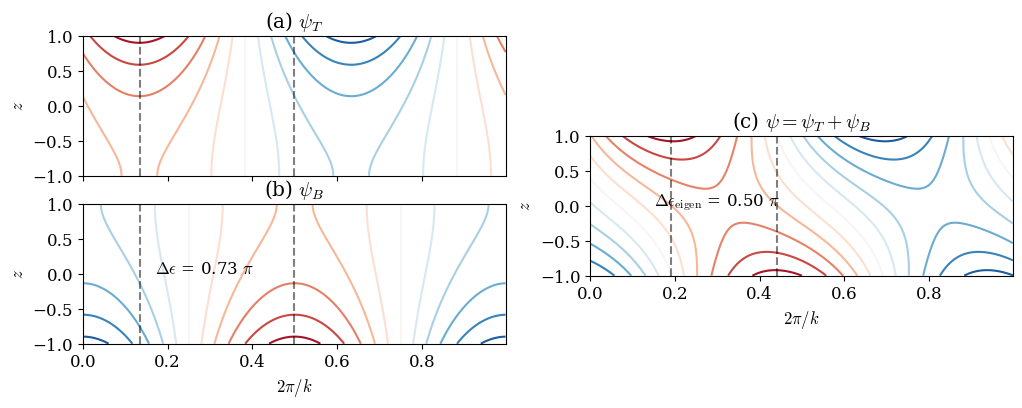

In [6]:
# demonstration of superposition of edge waves

k = k_max[delta_zero_ind]

deps, gamma = get_root(dF, k, delta_vec[delta_zero_ind], guess_init=[0.25*np.pi, 0.25*np.pi])

z_vec = np.linspace(-1, 1, 31)
x_vec = np.linspace(0, 2.0 * np.pi / k, 501, endpoint=False)

Bu, l = 1.0, 0.0
mu = Bu * np.sqrt(k**2 + l**2)

# by default set B = 1 and eps_B = 0, so T = tan(gamma) and eps_T = deps (note the shift in pi)
T = np.tan(gamma)
deps -= np.pi

psi_T = np.zeros((len(z_vec), len(x_vec)))
psi_B = np.zeros((len(z_vec), len(x_vec)))

for i in range(len(z_vec)):
        psi_T[i, :] = np.real(1.0 / (mu * np.sinh(2.0 * mu)) * np.exp(zi * k * x_vec) *
                              (T * np.exp(zi * deps) * np.cosh(mu * (1.0 + z_vec[i]))
                              )
                              )
        psi_B[i, :] = np.real(1.0 / (mu * np.sinh(2.0 * mu)) * np.exp(zi * k * x_vec) *
                              (-                       np.cosh(mu * (1.0 - z_vec[i]))
                              )
                              )
        
##

fig = plt.figure(figsize=(12, 4))

x_loc_l = x_vec[np.where(psi_T[-1, :] == np.max(psi_T[-1, :]))[0][0]] / (2.0 * np.pi / k)
x_loc_r = x_vec[np.where(psi_B[0, :] == np.max(psi_B[0, :]))[0][0]] / (2.0 * np.pi / k)
ax = plt.subplot(2, 2, 1)
ax.contour(x_vec / (2.0 * np.pi / k), z_vec, psi_T, 10)
ax.plot([x_loc_l, x_loc_l], [-1, 1], 'k--', alpha=0.5)
ax.plot([x_loc_r, x_loc_r], [-1, 1], 'k--', alpha=0.5)
ax.set_xticklabels([])
ax.set_ylabel(r"$z$")
ax.set_title(r"(a) $\psi_T$")

ax = plt.subplot(2, 2, 3)
ax.contour(x_vec / (2.0 * np.pi / k), z_vec, psi_B, 10)
ax.plot([x_loc_l, x_loc_l], [-1, 1], 'k--', alpha=0.5)
ax.plot([x_loc_r, x_loc_r], [-1, 1], 'k--', alpha=0.5)
ax.set_xlabel(r"$2\pi/k$")
ax.set_ylabel(r"$z$")
ax.set_title(r"(b) $\psi_B$")

x_diff = 2.0 * (x_loc_r - x_loc_l)
ax.text(0.17, 0.0, r"$\Delta\epsilon$ = %.2f $\pi$" % x_diff)

## combination

field = psi_T + psi_B

x_loc_l = x_vec[np.where(field[-1, :] == np.max(field[-1, :]))[0][0]] / (2.0 * np.pi / k)
x_loc_r = x_vec[np.where(field[0, :] == np.max(field[0, :]))[0][0]] / (2.0 * np.pi / k)
x_diff = 2.0 * (x_loc_r - x_loc_l)

ax = plt.subplot(2, 2, 2)
ax.contour(x_vec / (2.0 * np.pi / k), z_vec, psi_T + psi_B, 10)
ax.plot([x_loc_l, x_loc_l], [-1, 1], 'k--', alpha=0.5)
ax.plot([x_loc_r, x_loc_r], [-1, 1], 'k--', alpha=0.5)
ax.set_xlabel(r"$2\pi/k$")
ax.set_ylabel(r"$z$")
ax.set_title(r"(c) $\psi = \psi_T + \psi_B$")

ax.text(0.15, 0.0, r"$\Delta\epsilon_{\rm eigen}$ = %.2f $\pi$" % x_diff)

# shift the last axes
box = ax.get_position()
box.y0 -= 0.25
box.y1 -= 0.25
ax.set_position(box)

plt.savefig("./edge_vs_eigen_shift_l00.pdf", bbox_inches="tight")

In [7]:
# generate edge wave amplitude and phase (l = 0; quite different to l > 0...)

delta_vec = np.linspace(-2, 1, 301)
k_vec = np.linspace(1e-3, 2, 501)

amp_edge = np.zeros((len(k_vec), len(delta_vec)))
phase_edge = np.zeros((len(k_vec), len(delta_vec)))

n = 0
n_tot = np.sum(growth > 0)

# get_root1 solves finds zero of dynamical system
# get_root2 solves for gamma first, then evaluates eps (both gives the same answer when T/B in (0,1) )

for i in range(len(k_vec)):
    for j in range(len(delta_vec)):
        if growth[i, j] > 0:
#             phase_edge[i, j], amp_edge[i, j] = get_root(dF, k_vec[i], delta_vec[j], 
#                                                         guess_init=[0.5*np.pi, 0.25*np.pi])
            phase_edge[i, j], amp_edge[i, j] = get_root1(k_vec[i], delta_vec[j], 
                                                        guess_init=[0.5*np.pi, 0.25*np.pi])
        
            n += 1
            if n % 3000 == 0:
                print(f"processing {n} / {n_tot} non-zero entries...")
        
phase_edge[growth==0.0] = np.nan
amp_edge[growth==0.0] = np.nan

phase_edge_vec = np.zeros(len(delta_vec))
amp_edge_vec = np.zeros(len(delta_vec))

for j in range(len(delta_vec)-1):
    phase_edge_vec[j], amp_edge_vec[j] = get_root(dF, k_max[j], delta_vec[j], guess_init=[0.5*np.pi, 0.2*np.pi])

processing 3000 / 35922 non-zero entries...
processing 6000 / 35922 non-zero entries...
processing 9000 / 35922 non-zero entries...
processing 12000 / 35922 non-zero entries...
processing 15000 / 35922 non-zero entries...
processing 18000 / 35922 non-zero entries...
processing 21000 / 35922 non-zero entries...
processing 24000 / 35922 non-zero entries...
processing 27000 / 35922 non-zero entries...
processing 30000 / 35922 non-zero entries...
processing 33000 / 35922 non-zero entries...


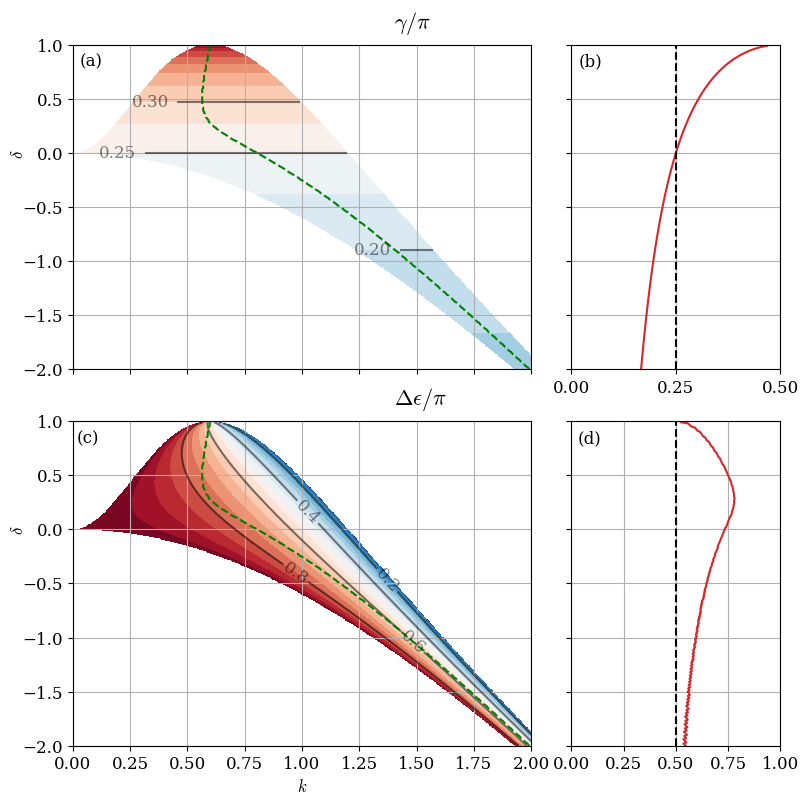

In [8]:
# plot of edge amplitude and phase

fig = plt.figure(figsize=(8, 8))

ax = plt.subplot2grid((2, 3), (0, 0), colspan=2)
cs = ax.contourf(k_vec, delta_vec, amp_edge.T / np.pi, levels=np.linspace(0, 0.5, 21))
# plt.colorbar(cs)
lines = ax.contour(k_vec, delta_vec, amp_edge.T / np.pi, levels=np.linspace(0, 0.3, 7), colors="k", alpha=0.5)
ax.clabel(lines, inline=1, colors='k')
ax.plot(k_max, delta_vec, 'g--')
ax.set_xlim((0, 2))
ax.grid()
# ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\delta$")
ax.yaxis.set_label_coords(-0.1, 0.665)
ax.set_xticklabels([])
ax.text(0.03, 0.8, r"(a)")
ax.text(1.4, 1.15, r"$\gamma / \pi$", fontsize=16)

ax = plt.subplot2grid((2, 3), (0, 2))
ax.plot(amp_edge_vec[:-1] / np.pi, delta_vec[:-1], "C3")
ax.plot([0.25, 0.25], [-2, 1], 'k--')
# ax.set_xlabel(r"$\gamma / \pi$")
# ax.set_ylabel(r"$\delta$")
ax.set_xlim([0, 0.5])
ax.set_ylim([-2, 1])
ax.set_yticklabels([])
ax.set_xticks([0, 0.25, 0.5])
ax.grid()
ax.text(0.018, 0.8, r"(b)")

ax = plt.subplot2grid((2, 3), (1, 0), colspan=2)
cs = ax.contourf(k_vec, delta_vec, phase_edge.T / np.pi, levels=np.linspace(0, 1, 21))
# plt.colorbar(cs)
lines = ax.contour(k_vec, delta_vec, phase_edge.T / np.pi, levels=np.linspace(0, 1, 6), colors="k", alpha=0.5)
ax.clabel(lines, inline=1,inline_spacing=0, colors='k')
ax.plot(k_max, delta_vec, 'g--')
ax.grid()
ax.set_xlim((0, 2))
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\delta$")
ax.yaxis.set_label_coords(-0.1, 0.665)
ax.text(0.018, 0.8, r"(c)")
ax.text(1.4, 1.15, r"$\Delta\epsilon / \pi$", fontsize=16)

ax = plt.subplot2grid((2, 3), (1, 2))
ax.plot(phase_edge_vec[:-1] / np.pi, delta_vec[:-1], "C3")
ax.plot([0.5, 0.5], [-2, 1], 'k--')
# ax.set_xlabel(r"$\Delta\epsilon / \pi$")
# ax.set_ylabel(r"$\delta$")
ax.set_xlim([0, 1])
ax.set_ylim([-2, 1])
ax.set_yticklabels([])
ax.grid()
ax.text(0.03, 0.8, r"(d)")

fig.tight_layout(pad=0.5)

plt.savefig("./amp_phase_from_edge_wave.pdf", bbox_inches="tight")

-----
## 3) analysis of eigenfunctions

In [9]:
# subroutines

def modified_eady_AB(k, delta, l=0.0, Bu=1.0):
    
    mu = Bu * np.sqrt(k**2 + l**2)
    
    # set up the entries of the matrix
    a11 = delta / (2.0 * mu) * np.cosh(mu)**2
    a12 = (1.0 - delta / 2.0) * np.cosh(mu) * np.sinh(mu) / mu - np.cosh(mu)**2
    a21 = (1.0 - delta / 2.0) * np.cosh(mu) * np.sinh(mu) / mu - np.sinh(mu)**2
    a22 = delta / (2.0 * mu) * np.sinh(mu)**2
    
    a11 /= -np.sinh(mu) * np.cosh(mu)
    a12 /= -np.sinh(mu) * np.cosh(mu)
    a21 /= -np.sinh(mu) * np.cosh(mu)
    a22 /= -np.sinh(mu) * np.cosh(mu)

    A = [[a11, a12], [a21, a22]]

    # compute eigenvectors and normalise so that v = is a unit vector; eigenvectors are v[:, i]
    c, v = np.linalg.eig(A)
    v[:, 0] /= np.sqrt(np.sum(np.abs(v[:, 0])))
    v[:, 1] /= np.sqrt(np.sum(np.abs(v[:, 1])))
    
    return c, v

def compute_amp_phase(z_vec, k, delta, l=0.0, Bu=1.0):
    
    _, v = modified_eady_AB(k, delta, l=l, Bu=Bu)
    
    mu = Bu * np.sqrt(k**2 + l**2)
    
    Phi_z = np.zeros((2, len(z_vec)), dtype=complex)  # need to declare complex otherwise only keeps real part
    Phi_z[0, :] = v[0, 0] * np.cosh(mu * z_vec) + v[1, 0] * np.sinh(mu * z_vec)
    Phi_z[1, :] = v[0, 1] * np.cosh(mu * z_vec) + v[1, 1] * np.sinh(mu * z_vec)
    
    amp = np.abs(Phi_z)
    phase = np.arctan2(np.imag(Phi_z), np.real(Phi_z)) / np.pi  # np.arctan2(y, x), in units of pi
    
    # normalise amplitude
    amp[0, :] /= np.max(np.abs(amp[0, :]))
    amp[1, :] /= np.max(np.abs(amp[1, :]))
    
    # reference phase to bottom boundary
    phase[0, :] -= phase[0, 0]
    phase[1, :] -= phase[1, 0]
    
    return amp, phase

def compute_eigen_2d(z_vec, x_vec, k, delta, l=0.0, Bu=1.0):
    
    _, v = modified_eady_AB(k, delta, l=l, Bu=Bu)
    
    mu = Bu * np.sqrt(k**2 + l**2)
    
    Phi_z = np.zeros((2, len(z_vec)), dtype=complex)  # need to declare complex otherwise only keeps real part
    dPhi_z = np.zeros((2, len(z_vec)), dtype=complex)
    
    Phi_z[0, :]  =       v[0, 0] * np.cosh(mu * z_vec) + v[1, 0] * np.sinh(mu * z_vec)
    Phi_z[1, :]  =       v[0, 1] * np.cosh(mu * z_vec) + v[1, 1] * np.sinh(mu * z_vec)
    dPhi_z[0, :] = mu * (v[0, 0] * np.sinh(mu * z_vec) + v[1, 0] * np.cosh(mu * z_vec))
    dPhi_z[1, :] = mu * (v[0, 1] * np.sinh(mu * z_vec) + v[1, 1] * np.cosh(mu * z_vec))

    psi = np.zeros((2, len(z_vec), len(x_vec)))
    b = np.zeros((2, len(z_vec), len(x_vec)))
    v = np.zeros((2, len(z_vec), len(x_vec)))
    for n in range(2):
        for i in range(len(z_vec)):
            psi[n, i, :] = np.real(Phi_z[n, i] * np.exp(zi * k * x_vec))
            b  [n, i, :] = np.real(dPhi_z[n, i] * np.exp(zi * k * x_vec))
            v  [n, i, :] = np.real(zi * k * Phi_z[n, i] * np.exp(zi * k * x_vec))
    
    return psi, b, v

def compute_eigen_3d(z_vec, y_vec, x_vec, k, delta, l=0.5, Bu=1.0):
    
    _, v = modified_eady_AB(k, delta, l=l, Bu=Bu)
    
    mu = Bu * np.sqrt(k**2 + l**2)
    
    Phi_z = np.zeros((2, len(z_vec)), dtype=complex)  # need to declare complex otherwise only keeps real part
    dPhi_z = np.zeros((2, len(z_vec)), dtype=complex)
    
    Phi_z[0, :]  =       v[0, 0] * np.cosh(mu * z_vec) + v[1, 0] * np.sinh(mu * z_vec)
    Phi_z[1, :]  =       v[0, 1] * np.cosh(mu * z_vec) + v[1, 1] * np.sinh(mu * z_vec)
    dPhi_z[0, :] = mu * (v[0, 0] * np.sinh(mu * z_vec) + v[1, 0] * np.cosh(mu * z_vec))
    dPhi_z[1, :] = mu * (v[0, 1] * np.sinh(mu * z_vec) + v[1, 1] * np.cosh(mu * z_vec))

    psi = np.zeros((2, len(z_vec), len(y_vec), len(x_vec)))
    b = np.zeros((2, len(z_vec), len(y_vec), len(x_vec)))
    v = np.zeros((2, len(z_vec), len(y_vec), len(x_vec)))
    u = np.zeros((2, len(z_vec), len(y_vec), len(x_vec)))
    for n in range(2):
        for j in range(len(y_vec)):
            for i in range(len(z_vec)):
                psi[n, i, j, :] = np.real(Phi_z[n, i] * np.exp(zi * k * x_vec) * np.sin(l * y_vec[j]))
                b[n, i, j, :] = np.real(dPhi_z[n, i] * np.exp(zi * k * x_vec) * np.sin(l * y_vec[j]))
                v[n, i, j, :] = np.real(zi * k * Phi_z[n, i] * np.exp(zi * k * x_vec) * np.sin(l * y_vec[j]))
                u[n, i, j, :] =-np.real(     l * Phi_z[n, i] * np.exp(zi * k * x_vec) * np.cos(l * y_vec[j]))

    return psi, b, v, u

In [10]:
# generate amplitude and phase (of eigenfunction)

z_vec = np.linspace(-1, 1, 31)

delta_vec = np.linspace(-2, 1, 301)
k_vec = np.linspace(1e-3, 2, 501)

amp = np.zeros((len(k_vec), len(delta_vec)))
phase = np.zeros((len(k_vec), len(delta_vec)))

n = 0
n_tot = np.sum(growth > 0)

for i in range(len(k_vec)):
    for j in range(len(delta_vec)):
        if growth[i, j] > 0:
            dum_amp, dum_phase = compute_amp_phase(z_vec, k_vec[i], delta_vec[j], l=0.0, Bu=1.0)
            amp[i, j] = np.arctan(dum_amp[0, -1] / dum_amp[0, 0])
            phase[i, j] = dum_phase[0, -1]
        
            n += 1
            if n % 3000 == 0:
                print(f"processing {n} / {n_tot} non-zero entries...")
        
phase[growth==0.0] = np.nan
amp[growth==0.0] = np.nan

amp_vec = np.zeros((2, len(delta_vec), len(z_vec)))
phase_vec = np.zeros((2, len(delta_vec), len(z_vec)))

for j in range(len(delta_vec)-1):
    amp_vec[:, j, :], phase_vec[:, j, :] = compute_amp_phase(z_vec, k_max[j], delta_vec[j], l=0.0, Bu=1.0)

processing 3000 / 35922 non-zero entries...
processing 6000 / 35922 non-zero entries...
processing 9000 / 35922 non-zero entries...
processing 12000 / 35922 non-zero entries...
processing 15000 / 35922 non-zero entries...
processing 18000 / 35922 non-zero entries...
processing 21000 / 35922 non-zero entries...
processing 24000 / 35922 non-zero entries...
processing 27000 / 35922 non-zero entries...
processing 30000 / 35922 non-zero entries...
processing 33000 / 35922 non-zero entries...


/tmp/ipykernel_852406/656327943.py:21: RuntimeWarning: invalid value encountered in divide
  ax.plot(np.arctan(amp_vec[0, :, -1] / amp_vec[0, :, 0]) / np.pi, delta_vec, "g")


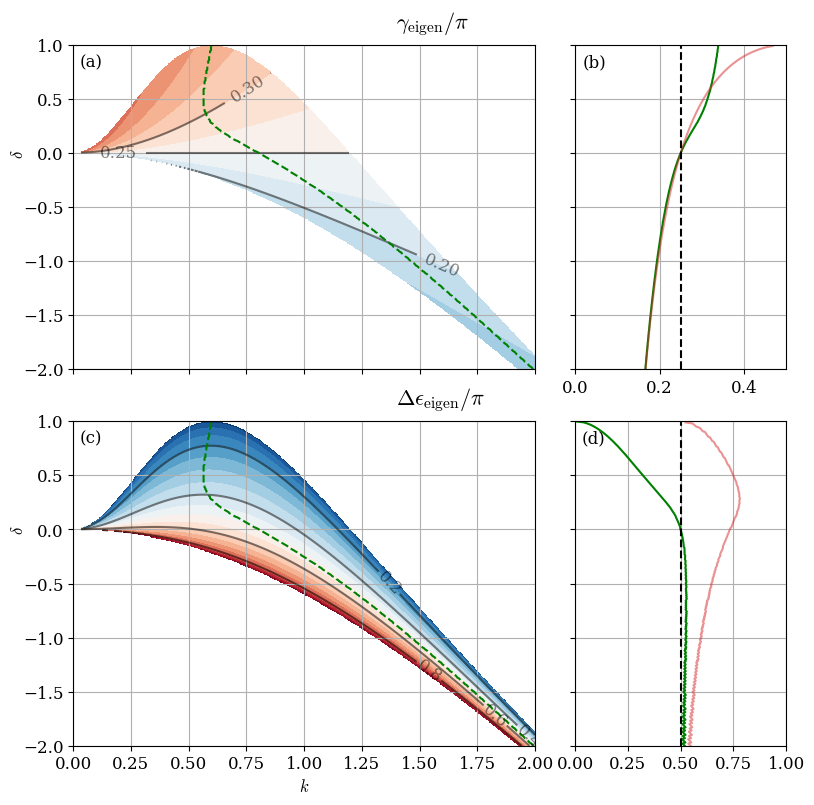

In [11]:
# plot of amplitude and phase

fig = plt.figure(figsize=(8, 8))

ax = plt.subplot2grid((2, 3), (0, 0), colspan=2)
cs = ax.contourf(k_vec, delta_vec, amp.T / np.pi, levels=np.linspace(0, 0.5, 21))
# plt.colorbar(cs)
lines = ax.contour(k_vec, delta_vec, amp.T / np.pi, levels=np.linspace(0, 0.3, 7), colors="k", alpha=0.5)
ax.clabel(lines, inline=1, colors='k')
ax.plot(k_max, delta_vec, 'g--')
ax.set_xlim((0, 2))
ax.grid()
# ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\delta$")
ax.yaxis.set_label_coords(-0.1, 0.665)
ax.set_xticklabels([])
ax.text(0.03, 0.8, r"(a)")
ax.text(1.4, 1.15, r"$\gamma_{\rm eigen} / \pi$", fontsize=16)

ax = plt.subplot2grid((2, 3), (0, 2))
ax.plot(np.arctan(amp_vec[0, :, -1] / amp_vec[0, :, 0]) / np.pi, delta_vec, "g")
ax.plot(amp_edge_vec[:-1] / np.pi, delta_vec[:-1], "C3", alpha=0.5)
ax.plot([0.25, 0.25], [-2, 1], 'k--')
# ax.set_xlabel(r"$\gamma_{\rm eigen} / \pi$")
# ax.set_ylabel(r"$\delta$")
ax.set_xlim([0, 0.5])
ax.set_ylim([-2, 1])
ax.set_yticklabels([])
ax.grid()
ax.text(0.018, 0.8, r"(b)")

ax = plt.subplot2grid((2, 3), (1, 0), colspan=2)
cs = ax.contourf(k_vec, delta_vec, phase.T, levels=np.linspace(0, 1, 21))
# plt.colorbar(cs)
lines = ax.contour(k_vec, delta_vec, phase.T, levels=np.linspace(0, 1, 6), colors="k", alpha=0.5)
ax.clabel(lines, inline=1,inline_spacing=0, colors='k')
ax.plot(k_max, delta_vec, 'g--')
ax.grid()
ax.set_xlim((0, 2))
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\delta$")
ax.yaxis.set_label_coords(-0.1, 0.665)
ax.text(0.03, 0.8, r"(c)")
ax.text(1.4, 1.15, r"$\Delta\epsilon_{\rm eigen} / \pi$", fontsize=16)

ax = plt.subplot2grid((2, 3), (1, 2))
ax.plot(phase_vec[0, :, -1], delta_vec, "g")
ax.plot(phase_edge_vec[:-1] / np.pi, delta_vec[:-1], "C3", alpha=0.5)
ax.plot([0.5, 0.5], [-2, 1], 'k--')
# ax.set_xlabel(r"$\Delta\epsilon_{\rm eigen} / \pi$")
# ax.set_ylabel(r"$\delta$")
ax.set_xlim([0, 1])
ax.set_ylim([-2, 1])
ax.set_yticklabels([])
ax.grid()
ax.text(0.03, 0.8, r"(d)")

fig.tight_layout(pad=0.5)

plt.savefig("./amp_phase_from_Phi.pdf", bbox_inches="tight")

## GEOMETRIC quantities

QG limit, from Marshall et al. (2012).

\begin{equation}
    \boldsymbol{\mathsf{E}} = \begin{pmatrix}-M + P & N & 0 \\ N & M+P & 0 \\ -S & R & 0 \end{pmatrix},
\end{equation}
\begin{equation}\begin{aligned}
    M &= \frac{1}{2}\overline{v'^2 - u'^2} &= -\gamma_m E \cos 2\phi_m \cos^2\lambda, \\
    N &= \overline{u'v'} &= \gamma_m E \sin 2\phi_m \cos^2\lambda,\\
    P &= \frac{1}{2 N_0}\overline{b'^2} &= E \sin^2\lambda,\\
    R &= \frac{f_0}{N_0^2}\overline{u'b'} &= \gamma_b \frac{f_0}{N_0} E \cos\phi_b \sin2\lambda,\\
    S &= \frac{f_0}{N_0^2}\overline{v'b'} &= \gamma_b \frac{f_0}{N_0} E \sin\phi_b \sin2\lambda.
\end{aligned}\end{equation}

GEOMETRIC quantities are
\begin{equation}\begin{aligned}
    \gamma_m = \frac{\sqrt{M^2 + N^2}}{K},\qquad \gamma_b = \frac{N_0}{2 f_0} \sqrt{\frac{R^2 + S^2}{KP}},\\
    \cos 2\phi_m = \frac{-M}{\sqrt{M^2 + N^2}},\qquad \cos \phi_b = \frac{R}{\sqrt{R^2 + S^2}},\\
    \frac{K}{E} = \cos^2\lambda, \quad \frac{P}{E}=\sin^2\lambda, \quad \tan^2\lambda = \frac{P}{K}.
\end{aligned}\end{equation}

Can additionally define
\begin{equation}
    \tan 2\phi_t = \gamma_b \tan 2\lambda, \quad \gamma_t = \frac{\cos 2\lambda}{\cos 2\phi_t}, \quad \alpha = \gamma_b \sin\phi_b \sin 2\lambda,
\end{equation}
and possibly $\alpha^* = \gamma_b \sin\phi_b$.

***Note***: 

1) if $l = 0$, then $u' = 0$, and
\begin{equation}
    R = N = 0, \quad M^2 = K,
\end{equation}
so
\begin{equation}
    \gamma_m = 1, \quad \phi_m = \frac{\pi}{2}, \quad \phi_b = \frac{\pi}{2}, \quad \alpha = \gamma_b \sin 2\lambda.
\end{equation}

2) degeneracy: $\sin\phi_b = S / \sqrt{R^2 + S^2}$, so for $l=0$, $\phi_b = \pm \pi/2$ depending on sign of $S$, which would then translate to $\alpha$ (rather than $\phi_t$) to denote whether a mode is stable or unstable.

3) by appropriate subsitutions, can show that, in general,
\begin{equation}
    \alpha = \gamma_t \sin 2\phi_t \sin \phi_b.
\end{equation}
In the previous case, most of the variation from $\alpha$ is from $\gamma_b$. In the $\gamma_t$ and $\phi_t$ formulation, both take some of the variations, and it is slightly less clear what is going on. This is in contrast to Wang Yan and Huaiyu's diagnoses from the nonlinear simulations, where they find most of the variation of $\alpha$ does come from $\phi_t$ rather than $\gamma_t$ (not sure if they diagnosed $\gamma_b$).

In [12]:
# subroutines

def compute_geometric_2d_full(z_vec, x_vec, k, delta, Bu=1.0):
    """
    Returns only the height dependent GEOMETRIC quantities after zonal average. Only for l=0 case.
    """
    
    # spit out the v and b field
    _, b, v = compute_eigen_2d(z_vec, x_vec, k, delta, l=0.0, Bu=Bu)
    
    # GEOMETRIC quantities (N and R are zero for l=0.0)
    M = K = np.mean(0.5 * v ** 2, axis=-1)
    P = np.mean(0.5 * b ** 2, axis=-1)
    S = np.mean(v * b, axis=-1)

    gamma_b = 0.5 * np.sqrt(S**2 / (K * P))  # S to distinguish stable/unstable (S < 0 for stable mode)
    lam = np.arctan(np.sqrt(P / K))
    alpha = gamma_b * np.sin(2.0 * lam)

#     phi_t = 0.5 * np.arctan(gamma_b * np.tan(2.0 * lam))
    phi_t = 0.5 * np.arctan2(gamma_b, 1.0 / np.tan(2.0 * lam))  # to avoid branch jump

    lam /= np.pi
    phi_t /= np.pi
    
    GEOM_raw  = {"M" : M, "K" : K, "P" : P, "S" : S}
    GEOM_proc = {"gamma_b" : gamma_b, "lam" : lam, "alpha" : alpha, "phi_t" : phi_t}
    
    return GEOM_raw, GEOM_proc

def compute_geometric_2d_avg(z_vec, x_vec, k, delta, Bu=1.0):
    """
    Returns only the domain (in this case height) averaged quantity of the first mode
    """

    # spit out the v and b field
    _, b, v = compute_eigen_2d(z_vec, x_vec, k, delta, l=0.0, Bu=Bu)
    
    # GEOMETRIC quantities (N and R are zero for l=0.0)
    M = K = np.mean(0.5 * v ** 2, axis=-1)
    P = np.mean(0.5 * b ** 2, axis=-1)
    S = np.mean(v * b, axis=-1)

    gamma_b = 0.5 * np.sqrt(S**2 / (K * P))  # S to distinguish stable/unstable (S < 0 for stable mode)
    lam = np.arctan(np.sqrt(P / K))
    alpha = gamma_b * np.sin(2.0 * lam)

#     phi_t = 0.5 * np.arctan(gamma_b * np.tan(2.0 * lam))
    phi_t = 0.5 * np.arctan2(gamma_b, 1.0 / np.tan(2.0 * lam))  # to avoid branch jump

    lam /= np.pi
    phi_t /= np.pi
    
    GEOM_proc = {"gamma_b" : np.mean(gamma_b[0, :], axis=-1), 
                 "lam" : np.mean(lam[0, :], axis=-1), 
                 "alpha" : np.mean(alpha[0, :], axis=-1), 
                 "phi_t" : np.mean(phi_t[0, :], axis=-1)}
    
    return GEOM_proc

def compute_geometric_2d_max(z_vec, x_vec, k, delta, Bu=1.0):
    """
    Returns only the domain (in this case height) averaged quantity of the first mode
    """

    # spit out the v and b field
    _, b, v = compute_eigen_2d(z_vec, x_vec, k, delta, l=0.0, Bu=Bu)
    
    # GEOMETRIC quantities (N and R are zero for l=0.0)
    M = K = np.mean(0.5 * v ** 2, axis=-1)
    P = np.mean(0.5 * b ** 2, axis=-1)
    S = np.mean(v * b, axis=-1)

    gamma_b = 0.5 * np.sqrt(S**2 / (K * P))  # S to distinguish stable/unstable (S < 0 for stable mode)
    lam = np.arctan(np.sqrt(P / K))
    alpha = gamma_b * np.sin(2.0 * lam)

    phi_t = 0.5 * np.arctan(gamma_b * np.tan(2.0 * lam))

    lam /= np.pi
    phi_t /= np.pi
    
    GEOM_proc = {"gamma_b" : np.max(gamma_b[0, :]), 
                 "lam" : np.max(lam[0, :]), 
                 "alpha" : np.max(alpha[0, :]), 
                 "phi_t" : np.max(phi_t[0, :])}
    
    return GEOM_proc

def compute_geometric_3d_full(z_vec, y_vec, x_vec, k, delta, l=0.5, Bu=1.0):
    """
    Returns the full 3d GEOMETRIC quantities
    """
    
    # spit out the v and b field
    _, b, v, u = compute_eigen_3d(z_vec, y_vec, x_vec, k, delta, l=l, Bu=Bu)
    
    # GEOMETRIC quantities (N and R are zero for l=0.0)
    M = np.mean(0.5 * (v ** 2 - u ** 2), axis=-1)
    N = np.mean(v * u , axis=-1)
    K = np.mean(0.5 * (u ** 2 + v ** 2), axis=-1)
    P = np.mean(0.5 * b ** 2, axis=-1)
    R = np.mean(u * b, axis=-1)
    S = np.mean(v * b, axis=-1)
    
    gamma_m = np.sqrt(M**2 + N**2) / K
    gamma_b = 0.5 * np.sqrt((R**2 + S**2) / (K * P))
    phi_m = 0.5 * np.arcsin( N / np.sqrt(M**2 + N**2))
    phi_b = 0.5 * np.arcsin( S / np.sqrt(R**2 + S**2))
    lam = np.arctan(np.sqrt(P / K))
    alpha = gamma_b * np.sin(phi_b) * np.sin(2.0 * lam)

#     phi_t = 0.5 * np.arctan(gamma_b * np.tan(2.0 * lam))
    phi_t = 0.5 * np.arctan2(gamma_b, 1.0 / np.tan(2.0 * lam))  # to avoid branch jump

    lam /= np.pi
    phi_t /= np.pi
    phi_m /= np.pi
    phi_b /= np.pi
    
    GEOM_raw  = {"M" : M, "N" : N, "K" : K, "P" : P, "R" : R, "S" : S}
    GEOM_proc = {"gamma_m" : gamma_m, "gamma_b" : gamma_b, 
                 "phi_m" : phi_m, "phi_b" : phi_b, 
                 "lam" : lam, "alpha" : alpha, "phi_t" : phi_t}
    
    return GEOM_raw, GEOM_proc

def compute_geometric_3d_avg(z_vec, y_vec, x_vec, k, delta, l=0.5, Bu=1.0):
    """
    Returns the full 3d GEOMETRIC quantities
    """
    
    # spit out the v and b field
    _, b, v, u = compute_eigen_3d(z_vec, y_vec, x_vec, k, delta, l=l, Bu=Bu)
    
    # GEOMETRIC quantities (N and R are zero for l=0.0)
    M = np.mean(0.5 * (v ** 2 - u ** 2), axis=-1)
    N = np.mean(v * u , axis=-1)
    K = np.mean(0.5 * (u ** 2 + v ** 2), axis=-1)
    P = np.mean(0.5 * b ** 2, axis=-1)
    R = np.mean(u * b, axis=-1)
    S = np.mean(v * b, axis=-1)
    
    gamma_m = np.sqrt(M**2 + N**2) / K
    gamma_b = 0.5 * np.sqrt((R**2 + S**2) / (K * P))
    phi_m = 0.5 * np.arcsin( N / np.sqrt(M**2 + N**2))
    phi_b = 0.5 * np.arcsin( S / np.sqrt(R**2 + S**2))
    lam = np.arctan(np.sqrt(P / K))
    alpha = gamma_b * np.sin(phi_b) * np.sin(2.0 * lam)

#     phi_t = 0.5 * np.arctan(gamma_b * np.tan(2.0 * lam))
    phi_t = 0.5 * np.arctan2(gamma_b, 1.0 / np.tan(2.0 * lam))  # to avoid branch jump

    lam /= np.pi
    phi_t /= np.pi
    phi_m /= np.pi
    phi_b /= np.pi
    
    GEOM_proc = {"gamma_m" : np.nanmean(np.nanmean(gamma_m[0, :, :], axis=-1), axis=-1), 
                 "gamma_b" : np.nanmean(np.nanmean(gamma_b[0, :, :], axis=-1), axis=-1), 
                 "phi_m" : np.nanmean(np.nanmean(phi_m[0, :, :], axis=-1), axis=-1), 
                 "phi_b" : np.nanmean(np.nanmean(phi_b[0, :, :], axis=-1), axis=-1), 
                 "lam" : np.nanmean(np.nanmean(lam[0, :, :], axis=-1), axis=-1), 
                 "alpha" : np.nanmean(np.nanmean(alpha[0, :, :], axis=-1), axis=-1),
                 "phi_t" : np.nanmean(np.nanmean(phi_t[0, :, :], axis=-1), axis=-1), }
    
    return GEOM_proc

In [13]:
# generate processed quantities

z_vec = np.linspace(-1, 1, 31)

delta_vec = np.linspace(-2, 1, 301)
k_vec = np.linspace(1e-3, 2, 501)

alpha = np.zeros((len(k_vec), len(delta_vec)))
lam = np.zeros((len(k_vec), len(delta_vec)))
phi_t = np.zeros((len(k_vec), len(delta_vec)))
gamma_b = np.zeros((len(k_vec), len(delta_vec)))

n = 0
n_tot = np.sum(growth > 0)

for i in range(len(k_vec)):
    for j in range(len(delta_vec)-1):
        if growth[i, j] > 0:
            x_vec = np.linspace(0, 2.0 * np.pi / k_vec[i], 51, endpoint=False)
            GEOM_proc = compute_geometric_2d_avg(z_vec, x_vec, k_vec[i], delta_vec[j], Bu=1.0)
        #     GEOM_proc = compute_geometric_2d_max(z_vec, x_vec, k_max[j], delta_vec[j], Bu=1.0)
            alpha[i, j] = GEOM_proc["alpha"]
            lam[i, j] = GEOM_proc["lam"]
            phi_t[i, j] = GEOM_proc["phi_t"]
            gamma_b[i, j] = GEOM_proc["gamma_b"]
            
            n += 1
            if n % 3000 == 0:
                print(f"processing {n} / {n_tot} non-zero entries...")
        
alpha[growth==0.0] = np.nan
lam[growth==0.0] = np.nan
phi_t[growth==0.0] = np.nan
gamma_b[growth==0.0] = np.nan

alpha_vec = np.zeros(len(delta_vec))
gamma_b_vec = np.zeros(len(delta_vec))
phi_t_vec = np.zeros(len(delta_vec))

for j in range(len(delta_vec)-1):
    x_vec = np.linspace(0, 2.0 * np.pi / k_max[j], 51, endpoint=False)
    GEOM_proc = compute_geometric_2d_avg(z_vec, x_vec, k_max[j], delta_vec[j], Bu=1.0)
    alpha_vec[j] = GEOM_proc["alpha"]
    gamma_b_vec[j] = GEOM_proc["gamma_b"]
    phi_t_vec[j] = GEOM_proc["phi_t"]

processing 3000 / 35922 non-zero entries...
processing 6000 / 35922 non-zero entries...
processing 9000 / 35922 non-zero entries...
processing 12000 / 35922 non-zero entries...
processing 15000 / 35922 non-zero entries...
processing 18000 / 35922 non-zero entries...
processing 21000 / 35922 non-zero entries...
processing 24000 / 35922 non-zero entries...
processing 27000 / 35922 non-zero entries...
processing 30000 / 35922 non-zero entries...
processing 33000 / 35922 non-zero entries...


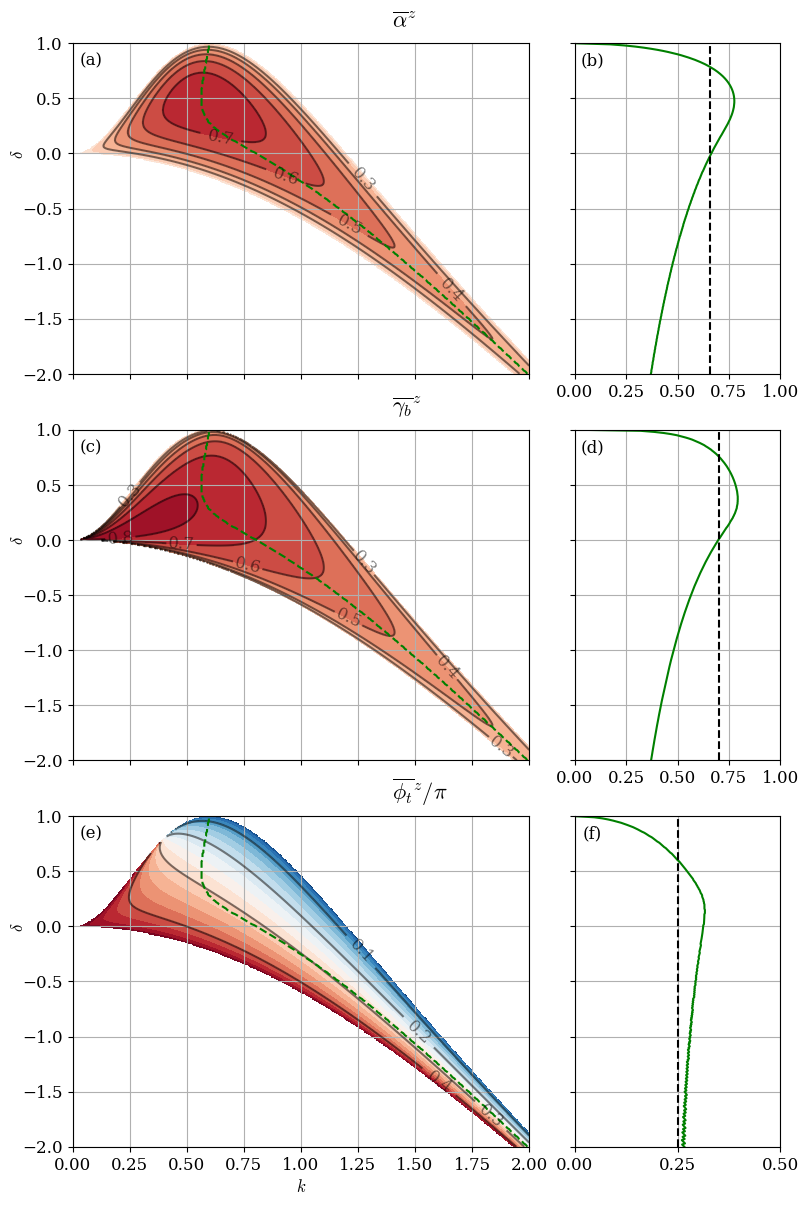

In [14]:
# plot of alpha, gamma and phi_t

fig = plt.figure(figsize=(8, 12))

ax = plt.subplot2grid((3, 3), (0, 0), colspan=2)
cs = ax.contourf(k_vec, delta_vec, alpha.T, levels=np.linspace(-1, 1, 21))
# plt.colorbar(cs)
lines = ax.contour(k_vec, delta_vec, alpha.T, levels=np.arange(0.3, 1, 0.1), colors="k", alpha=0.5)
ax.clabel(lines, inline=1, colors='k')
ax.plot(k_max, delta_vec, 'g--')
ax.set_xlim((0, 2))
ax.grid()
# ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\delta$")
ax.yaxis.set_label_coords(-0.1, 0.665)
ax.set_xticklabels([])
ax.text(0.03, 0.8, r"(a)")
ax.text(1.4, 1.15, r"$\overline{\alpha}^z$", fontsize=16)

ax = plt.subplot2grid((3, 3), (0, 2))
ax.plot(alpha_vec, delta_vec, "g")
ax.plot([0.66, 0.66], [-2, 1], 'k--')
# ax.set_xlabel(r"$\overline{\alpha}^z$")
# ax.set_ylabel(r"$\delta$")
ax.set_xlim([0, 1])
ax.set_ylim([-2, 1])
ax.set_yticklabels([])
ax.grid()
ax.text(0.03, 0.8, r"(b)")

ax = plt.subplot2grid((3, 3), (1, 0), colspan=2)
cs = ax.contourf(k_vec, delta_vec, gamma_b.T, levels=np.linspace(-1, 1, 21))
# plt.colorbar(cs)
lines = ax.contour(k_vec, delta_vec, gamma_b.T, levels=np.arange(0.3, 1, 0.1), colors="k", alpha=0.5)
ax.clabel(lines, inline=1,inline_spacing=0, colors='k')
ax.plot(k_max, delta_vec, 'g--')
ax.grid()
ax.set_xlim((0, 2))
ax.set_ylabel(r"$\delta$")
ax.yaxis.set_label_coords(-0.1, 0.665)
ax.set_xticklabels([])
ax.text(1.4, 1.15, r"$\overline{\gamma_b}^z$", fontsize=16)
ax.text(0.03, 0.8, r"(c)")

ax = plt.subplot2grid((3, 3), (1, 2))
ax.plot(gamma_b_vec, delta_vec, "g")
ax.plot([0.7, 0.7], [-2, 1], 'k--')
# ax.set_xlabel(r"$\overline{\gamma_b}^z$")
# ax.set_ylabel(r"$\delta$")
ax.set_xlim([0, 1])
ax.set_ylim([-2, 1])
ax.set_yticklabels([])
ax.grid()
ax.text(0.03, 0.8, r"(d)")

ax = plt.subplot2grid((3, 3), (2, 0), colspan=2)
cs = ax.contourf(k_vec, delta_vec, phi_t.T, levels=np.linspace(0, 0.5, 21))
# plt.colorbar(cs)
lines = ax.contour(k_vec, delta_vec, phi_t.T, levels=np.arange(0, 0.5, 0.1), colors="k", alpha=0.5)
ax.clabel(lines, inline=1, colors='k')
ax.plot(k_max, delta_vec, 'g--')
ax.set_xlim((0, 2))
ax.grid()
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\delta$")
ax.yaxis.set_label_coords(-0.1, 0.665)
ax.text(1.4, 1.15, r"$\overline{\phi_t}^z / \pi$", fontsize=16)
ax.text(0.03, 0.8, r"(e)")

ax = plt.subplot2grid((3, 3), (2, 2))
ax.plot(phi_t_vec, delta_vec, "g")
ax.plot([0.25, 0.25], [-2, 1], 'k--')
# ax.set_xlabel(r"$\overline{\phi_t}^z$")
# ax.set_ylabel(r"$\delta$")
ax.set_xlim([0, 0.5])
ax.set_ylim([-2, 1])
ax.set_yticklabels([])
ax.set_xticks([0, 0.25, 0.5])
ax.grid()
ax.text(0.018, 0.8, r"(f)")

fig.tight_layout(pad=0.5)

plt.savefig("./eigen_geometric_l00.pdf", bbox_inches="tight")

Text(0.5, 1.0, '$k=1.19$ ($\\delta=0, l=0$)')

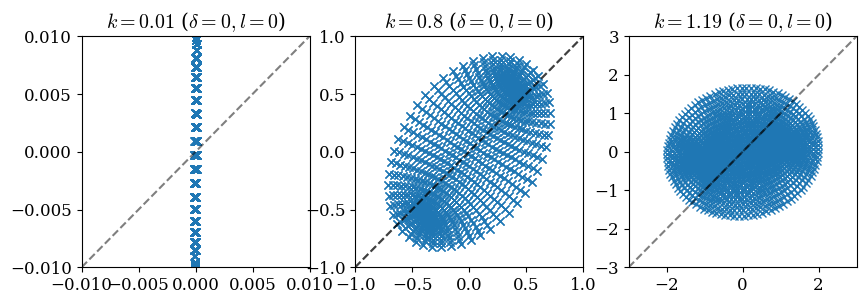

In [15]:
# scatter plot of eddy variance ellipse (of b' against v' here) (l=0 here, but similar for other)

fig = plt.figure(figsize=(10, 3))

delta = 0.0
z_vec = np.linspace(-1, 1, 31)

k = 0.01
x_vec = np.linspace(0, 2.0 * np.pi / k, 51, endpoint=False)
psi, b, v = compute_eigen_2d(z_vec, x_vec, k, delta, l=0.0, Bu=1.0)

ax = plt.subplot(1, 3, 1)
ax.plot(v[0, :, :].flatten(), b[0, :, :].flatten(), 'x')
lim = 1e-2
ax.plot([-lim, lim], [-lim, lim], 'k--', alpha=0.5)
ax.set(xlim=(-lim, lim), ylim=(-lim, lim))
ax.set_title(f"$k={k}$ ($\delta=0, l=0$)")

k = 0.8
x_vec = np.linspace(0, 2.0 * np.pi / k, 51, endpoint=False)
psi, b, v = compute_eigen_2d(z_vec, x_vec, k, delta, l=0.0, Bu=1.0)

ax = plt.subplot(1, 3, 2)
ax.plot(v[0, :, :].flatten(), b[0, :, :].flatten(), 'x')
ax.plot([-1, 1], [-1, 1], 'k--', alpha=0.5)
lim = 1
ax.plot([-lim, lim], [-lim, lim], 'k--', alpha=0.5)
ax.set(xlim=(-lim, lim), ylim=(-lim, lim))
ax.set_title(f"$k={k}$ ($\delta=0, l=0$)")

k = 1.19
x_vec = np.linspace(0, 2.0 * np.pi / k, 51, endpoint=False)
psi, b, v = compute_eigen_2d(z_vec, x_vec, k, delta, l=0.0, Bu=1.0)

ax = plt.subplot(1, 3, 3)
ax.plot(v[0, :, :].flatten(), b[0, :, :].flatten(), 'x')
ax.plot([-1, 1], [-1, 1], 'k--', alpha=0.5)
lim = 3
ax.plot([-lim, lim], [-lim, lim], 'k--', alpha=0.5)
ax.set(xlim=(-lim, lim), ylim=(-lim, lim))
ax.set_title(f"$k={k}$ ($\delta=0, l=0$)")

-----
## 4) sample analysis of things with $l=0.5$

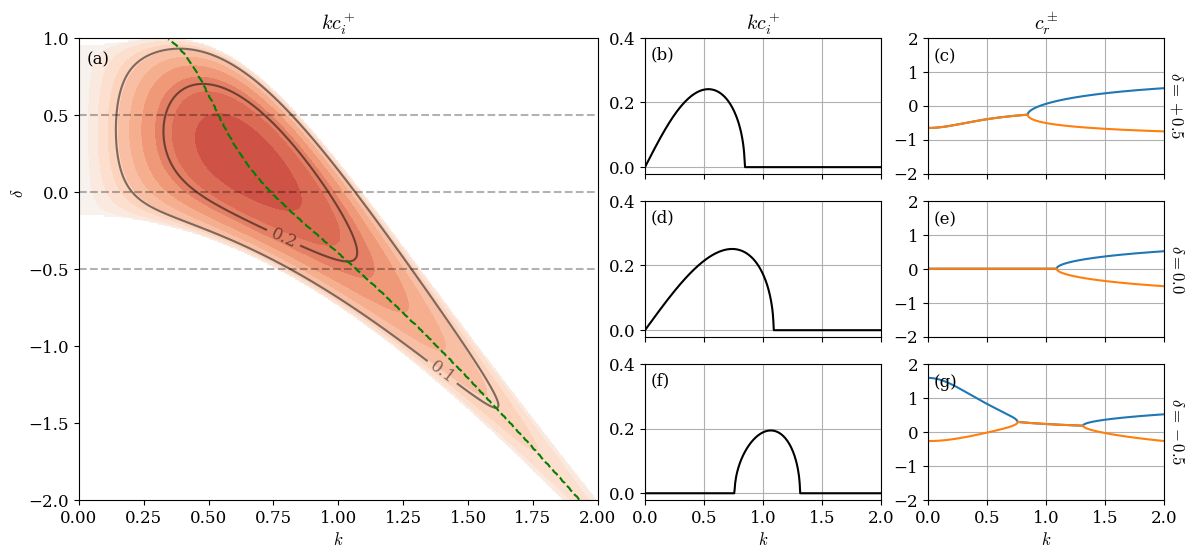

In [16]:
# general characteristics (l = 0.5)

delta_vec = np.linspace(-2, 1, 301)
k_vec = np.linspace(1e-3, 2, 501)

c_p = np.zeros((len(k_vec), len(delta_vec)), dtype=complex)
c_m = np.zeros((len(k_vec), len(delta_vec)), dtype=complex)

for i in range(len(k_vec)):
    for j in range(len(delta_vec)):
        c_p[i, j], c_m[i, j] = modified_eady(k_vec[i], delta_vec[j], l=0.5)  # l=0 and l>0 are quite different...

# compute other useful quantities
growth = k_vec[:, np.newaxis] * np.imag(c_p)
k_c = np.zeros(len(delta_vec))
k_max = np.zeros(len(delta_vec))
for j in range(len(delta_vec)):
#     k_c[j] = find_kc(k_vec, c_p[:, j])
    k_max[j] = find_kmax(k_vec, growth[:, j])

fig = plt.figure(figsize=(14, 6))

ax = plt.subplot2grid((3, 4), (0, 0), rowspan=3, colspan=2)
growth_dum = np.zeros(growth.shape)
growth_dum[:] = growth[:]
growth_dum[growth==0.0] = np.nan
ax.contourf(k_vec, delta_vec, growth_dum.T, levels=np.linspace(-0.4, 0.4, 31), cmap="RdBu_r")
lines = ax.contour(k_vec, delta_vec, growth_dum.T, levels=np.arange(0, 0.5, 0.1), colors="k", alpha=0.5)
ax.clabel(lines, inline=1, colors='k')
ax.plot([0, 2], [0.5, 0.5], 'k--', alpha=0.3)
ax.plot([0, 2], [0, 0], 'k--', alpha=0.3)
ax.plot([0, 2], [-0.5, -0.5], 'k--', alpha=0.3)
k_max[-1] = np.nan
plt.plot(k_max, delta_vec, 'g--')
ax.set_xlim((0, 2))
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\delta$")
ax.yaxis.set_label_coords(-0.1, 0.665)
ax.set_title(r"$kc^+_i$")
ax.text(0.03, 0.83, r"(a)")

delta_neg_ind = np.where(delta_vec==-0.5)[0][0]
delta_zero_ind = np.where(delta_vec==0)[0][0]
delta_pos_ind = np.where(delta_vec==+0.5)[0][0]

ax = plt.subplot2grid((3, 4), (0, 2))
ax.plot(k_vec, growth[:, delta_pos_ind], "k", label=r"$kc_{+,i}$")
ax.set_xlim((0, 2))
ax.set_ylim((-0.02, 0.4))
ax.set_xticklabels([])
ax.set_title(r"$kc^+_i$")
ax.grid()
ax.text(0.05, 0.335, r"(b)")
ax = plt.subplot2grid((3, 4), (1, 2))
ax.plot(k_vec, growth[:, delta_zero_ind], "k", label=r"$kc_{+,i}$")
ax.set_xlim((0, 2))
ax.set_ylim((-0.02, 0.4))
ax.set_xticklabels([])
ax.grid()
ax.text(0.05, 0.335, r"(d)")
ax = plt.subplot2grid((3, 4), (2, 2))
ax.plot(k_vec, growth[:, delta_neg_ind], "k", label=r"$kc_{+,i}$")
ax.set_xlim((0, 2))
ax.set_ylim((-0.02, 0.4))
ax.set_xlabel(r"$k$")
ax.grid()
ax.text(0.05, 0.335, r"(f)")

ax = plt.subplot2grid((3, 4), (0, 3))
ax.plot(k_vec, np.real(c_p[:, delta_pos_ind]), "C0", label=r"$c_{+,r}$")
ax.plot(k_vec, np.real(c_m[:, delta_pos_ind]), "C1", label=r"$c_{-,r}$")
ax.set_xlim((0, 2))
ax.set_ylim((-2, 2))
ax.set_xticklabels([])
ax.yaxis.set_label_position("right")
ax.set_ylabel(r"$\delta = +0.5$", rotation=-90, labelpad=15)
ax.set_title(r"$c_r^\pm$")
ax.grid()
ax.text(0.05, 1.32, r"(c)")
ax = plt.subplot2grid((3, 4), (1, 3))
ax.plot(k_vec, np.real(c_p[:, delta_zero_ind]), "C0", label=r"$c_{+,r}$")
ax.plot(k_vec, np.real(c_m[:, delta_zero_ind]), "C1", label=r"$c_{-,r}$")
ax.set_xlim((0, 2))
ax.set_ylim((-2, 2))
ax.set_xticklabels([])
ax.yaxis.set_label_position("right")
ax.set_ylabel(r"$\delta = 0.0$", rotation=-90, labelpad=15)
ax.grid()
ax.text(0.05, 1.32, r"(e)")
ax = plt.subplot2grid((3, 4), (2, 3))
ax.plot(k_vec, np.real(c_p[:, delta_neg_ind]), "C0", label=r"$c_{+,r}$")
ax.plot(k_vec, np.real(c_m[:, delta_neg_ind]), "C1", label=r"$c_{-,r}$")
ax.set_xlim((0, 2))
ax.set_ylim((-2, 2))
ax.set_xlabel(r"$k$")
ax.yaxis.set_label_position("right")
ax.set_ylabel(r"$\delta = -0.5$", rotation=-90, labelpad=15)
ax.grid()
ax.text(0.05, 1.32, r"(g)")

plt.savefig("./growth_rates_cr_l05.pdf", bbox_inches="tight")

In [17]:
# generate amplitude and phase (l = 0.5)

z_vec = np.linspace(-1, 1, 31)

delta_vec = np.linspace(-2, 1, 301)
k_vec = np.linspace(1e-3, 2, 501)

amp = np.zeros((len(k_vec), len(delta_vec)))
phase = np.zeros((len(k_vec), len(delta_vec)))

n = 0
n_tot = np.sum(growth > 0)

for i in range(len(k_vec)):
    for j in range(len(delta_vec)):
        if growth[i, j] > 0:
            dum_amp, dum_phase = compute_amp_phase(z_vec, k_vec[i], delta_vec[j], l=0.5, Bu=1.0)
            amp[i, j] = np.arctan(dum_amp[0, -1] / dum_amp[0, 0])
            phase[i, j] = dum_phase[0, -1]
        
            n += 1
            if n % 3000 == 0:
                print(f"processing {n} / {n_tot} non-zero entries...")
        
phase[growth==0.0] = np.nan
amp[growth==0.0] = np.nan

amp_vec = np.zeros((2, len(delta_vec), len(z_vec)))
phase_vec = np.zeros((2, len(delta_vec), len(z_vec)))

for j in range(len(delta_vec)-1):
    amp_vec[:, j, :], phase_vec[:, j, :] = compute_amp_phase(z_vec, k_max[j], delta_vec[j], l=0.0, Bu=1.0)

processing 3000 / 41806 non-zero entries...
processing 6000 / 41806 non-zero entries...
processing 9000 / 41806 non-zero entries...
processing 12000 / 41806 non-zero entries...
processing 15000 / 41806 non-zero entries...
processing 18000 / 41806 non-zero entries...
processing 21000 / 41806 non-zero entries...
processing 24000 / 41806 non-zero entries...
processing 27000 / 41806 non-zero entries...
processing 30000 / 41806 non-zero entries...
processing 33000 / 41806 non-zero entries...
processing 36000 / 41806 non-zero entries...
processing 39000 / 41806 non-zero entries...


/tmp/ipykernel_852406/114648281.py:19: RuntimeWarning: invalid value encountered in divide
  ax.plot(np.arctan(amp_vec[0, :, -1] / amp_vec[0, :, 0]) / np.pi, delta_vec, "g")


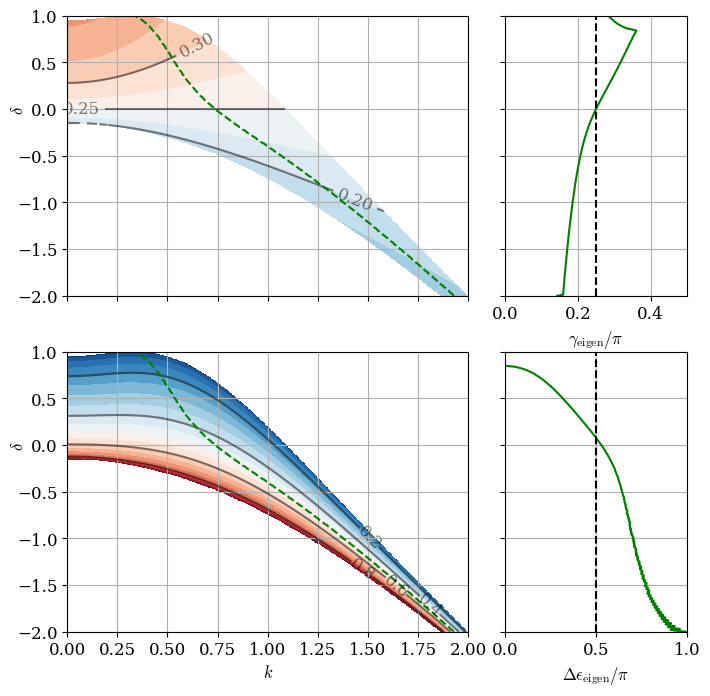

In [18]:
# plot of amplitude and phase

fig = plt.figure(figsize=(8, 8))

ax = plt.subplot2grid((2, 3), (0, 0), colspan=2)
cs = ax.contourf(k_vec, delta_vec, amp.T / np.pi, levels=np.linspace(0, 0.5, 21))
# plt.colorbar(cs)
lines = ax.contour(k_vec, delta_vec, amp.T / np.pi, levels=np.linspace(0, 0.3, 7), colors="k", alpha=0.5)
ax.clabel(lines, inline=1, colors='k')
ax.plot(k_max, delta_vec, 'g--')
ax.set_xlim((0, 2))
ax.grid()
# ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\delta$")
ax.yaxis.set_label_coords(-0.1, 0.665)
ax.set_xticklabels([])

ax = plt.subplot2grid((2, 3), (0, 2))
ax.plot(np.arctan(amp_vec[0, :, -1] / amp_vec[0, :, 0]) / np.pi, delta_vec, "g")
ax.plot([0.25, 0.25], [-2, 1], 'k--')
ax.set_xlabel(r"$\gamma_{\rm eigen} / \pi$")
# ax.set_ylabel(r"$\delta$")
ax.set_xlim([0, 0.5])
ax.set_ylim([-2, 1])
ax.set_yticklabels([])
ax.grid()

ax = plt.subplot2grid((2, 3), (1, 0), colspan=2)
cs = ax.contourf(k_vec, delta_vec, phase.T, levels=np.linspace(0, 1, 21))
# plt.colorbar(cs)
lines = ax.contour(k_vec, delta_vec, phase.T, levels=np.linspace(0, 1, 6), colors="k", alpha=0.5)
ax.clabel(lines, inline=1,inline_spacing=0, colors='k')
ax.plot(k_max, delta_vec, 'g--')
ax.grid()
ax.set_xlim((0, 2))
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\delta$")
ax.yaxis.set_label_coords(-0.1, 0.665)

ax = plt.subplot2grid((2, 3), (1, 2))
ax.plot(phase_vec[0, :, -1], delta_vec, "g")
ax.plot([0.5, 0.5], [-2, 1], 'k--')
ax.set_xlabel(r"$\Delta\epsilon_{\rm eigen} / \pi$")
# ax.set_ylabel(r"$\delta$")
ax.set_xlim([0, 1])
ax.set_ylim([-2, 1])
ax.set_yticklabels([])
ax.grid()

# plt.savefig("./amp_phase_from_Phi_l05.pdf", bbox_inches="tight")

### edge waves

In [19]:
# generate edge wave amplitude and phase

delta_vec = np.linspace(-2, 1, 301)
k_vec = np.linspace(1e-3, 2, 501)

amp_edge = np.zeros((len(k_vec), len(delta_vec)))
phase_edge = np.zeros((len(k_vec), len(delta_vec)))

n = 0
n_tot = np.sum(growth > 0)

# get_root1 solves finds zero of dynamical system
# get_root2 solves for gamma first, then evaluates eps (both gives the same answer when T/B in (0,1) )

for i in range(len(k_vec)):
    for j in range(len(delta_vec)):
        if growth[i, j] > 0:
#             phase_edge[i, j], amp_edge[i, j] = get_root(dF, k_vec[i], delta_vec[j], 
#                                                         guess_init=[0.5*np.pi, 0.25*np.pi],
#                                                         l=0.5)
            phase_edge[i, j], amp_edge[i, j] = get_root1(k_vec[i], delta_vec[j], 
                                                        guess_init=[0.5*np.pi, 0.25*np.pi],
                                                        l=0.5)
        
            n += 1
            if n % 3000 == 0:
                print(f"processing {n} / {n_tot} non-zero entries...")
        
phase_edge[growth==0.0] = np.nan
amp_edge[growth==0.0] = np.nan

phase_edge_vec = np.zeros(len(delta_vec))
amp_edge_vec = np.zeros(len(delta_vec))

for j in range(len(delta_vec)-1):
    phase_edge_vec[j], amp_edge_vec[j] = get_root(dF, k_max[j], delta_vec[j], 
                                                  guess_init=[0.5*np.pi, 0.25*np.pi], l=0.5)

processing 3000 / 41806 non-zero entries...
processing 6000 / 41806 non-zero entries...
processing 9000 / 41806 non-zero entries...
processing 12000 / 41806 non-zero entries...
processing 15000 / 41806 non-zero entries...
processing 18000 / 41806 non-zero entries...
processing 21000 / 41806 non-zero entries...
processing 24000 / 41806 non-zero entries...
processing 27000 / 41806 non-zero entries...
processing 30000 / 41806 non-zero entries...
processing 33000 / 41806 non-zero entries...
processing 36000 / 41806 non-zero entries...
processing 39000 / 41806 non-zero entries...


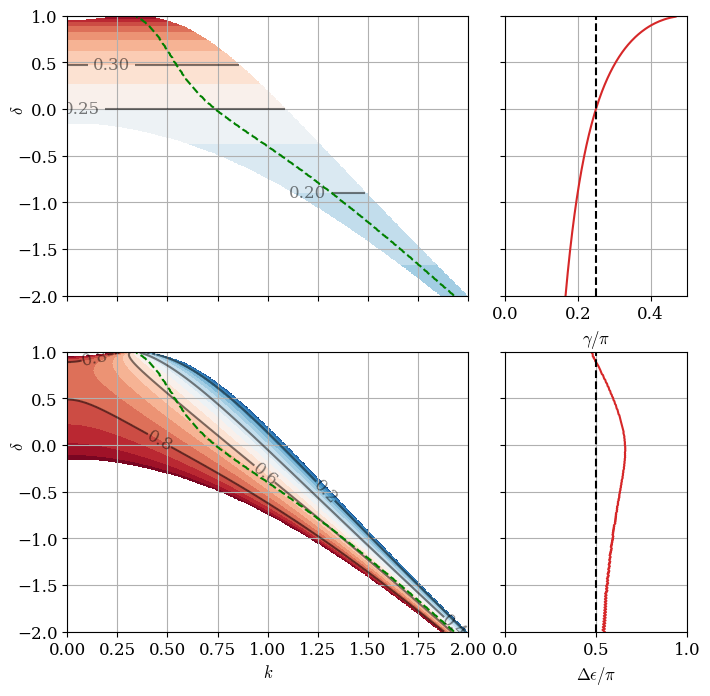

In [20]:
# plot of edge amplitude and phase

fig = plt.figure(figsize=(8, 8))

ax = plt.subplot2grid((2, 3), (0, 0), colspan=2)
cs = ax.contourf(k_vec, delta_vec, amp_edge.T / np.pi, levels=np.linspace(0, 0.5, 21))
# plt.colorbar(cs)
lines = ax.contour(k_vec, delta_vec, amp_edge.T / np.pi, levels=np.linspace(0, 0.3, 7), colors="k", alpha=0.5)
ax.clabel(lines, inline=1, colors='k')
ax.plot(k_max, delta_vec, 'g--')
ax.set_xlim((0, 2))
ax.grid()
# ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\delta$")
ax.yaxis.set_label_coords(-0.1, 0.665)
ax.set_xticklabels([])

ax = plt.subplot2grid((2, 3), (0, 2))
ax.plot(amp_edge_vec[:-1] / np.pi, delta_vec[:-1], "C3")
ax.plot([0.25, 0.25], [-2, 1], 'k--')
ax.set_xlabel(r"$\gamma / \pi$")
# ax.set_ylabel(r"$\delta$")
ax.set_xlim([0, 0.5])
ax.set_ylim([-2, 1])
ax.set_yticklabels([])
ax.grid()

ax = plt.subplot2grid((2, 3), (1, 0), colspan=2)
cs = ax.contourf(k_vec, delta_vec, phase_edge.T / np.pi, levels=np.linspace(0, 1, 21))
# plt.colorbar(cs)
lines = ax.contour(k_vec, delta_vec, phase_edge.T / np.pi, levels=np.linspace(0, 1, 6), colors="k", alpha=0.5)
ax.clabel(lines, inline=1,inline_spacing=0, colors='k')
ax.plot(k_max, delta_vec, 'g--')
ax.grid()
ax.set_xlim((0, 2))
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\delta$")
ax.yaxis.set_label_coords(-0.1, 0.665)

ax = plt.subplot2grid((2, 3), (1, 2))
ax.plot(phase_edge_vec[:-1] / np.pi, delta_vec[:-1], "C3")
ax.plot([0.5, 0.5], [-2, 1], 'k--')
ax.set_xlabel(r"$\Delta\epsilon / \pi$")
# ax.set_ylabel(r"$\delta$")
ax.set_xlim([0, 1])
ax.set_ylim([-2, 1])
ax.set_yticklabels([])
ax.grid()

# plt.savefig("./amp_phase_from_edge_wave_l05.pdf", bbox_inches="tight")

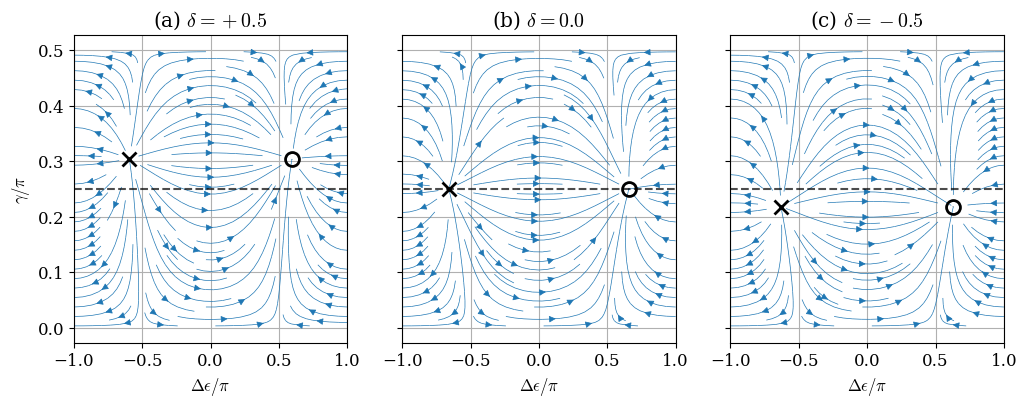

In [21]:
# phase portraits

deps, gamma = np.meshgrid(np.linspace(-np.pi, np.pi, 101), np.linspace(0.01, np.pi/2.0-0.01, 101))

points = np.asarray([deps, gamma])

fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 3, 1)
k = k_max[delta_pos_ind]
delta = 0.5
eps_dot, gamma_dot = dF(points, k, delta, l=0.5, Bu=1.0)
ax.streamplot(deps / np.pi, gamma / np.pi, eps_dot, gamma_dot, linewidth=0.5)
ax.plot([-1.0, 1.0], [0.25, 0.25], 'k--', alpha=0.7)
pos_root = get_root(dF, k, delta, guess_init=[0.25*np.pi, 0.25*np.pi], l=0.5)
neg_root = get_root(dF, k, delta, guess_init=[-0.25*np.pi, 0.25*np.pi], l=0.5)
ax.plot(pos_root[0] / np.pi, pos_root[1] / np.pi, 'ko', markersize=10, markerfacecolor='none', markeredgewidth=2)
ax.plot(neg_root[0] / np.pi, neg_root[1] / np.pi, 'kx', markersize=10, markerfacecolor='none', markeredgewidth=2)
ax.set_xlabel(r"$\Delta\epsilon / \pi$")
ax.set_ylabel(r"$\gamma / \pi$")
ax.set_title(r"(a) $\delta = +0.5$")
ax.grid()

ax = plt.subplot(1, 3, 2)
k = k_max[delta_zero_ind]
delta = 0.0
eps_dot, gamma_dot = dF(points, k, delta, l=0.5, Bu=1.0)
ax.streamplot(deps / np.pi, gamma / np.pi, eps_dot, gamma_dot, linewidth=0.5)
ax.plot([-1.0, 1.0], [0.25, 0.25], 'k--', alpha=0.7)
pos_root = get_root(dF, k, delta, guess_init=[0.25*np.pi, 0.25*np.pi], l=0.5)
neg_root = get_root(dF, k, delta, guess_init=[-0.25*np.pi, 0.25*np.pi], l=0.5)
ax.plot(pos_root[0] / np.pi, pos_root[1] / np.pi, 'ko', markersize=10, markerfacecolor='none', markeredgewidth=2)
ax.plot(neg_root[0] / np.pi, neg_root[1] / np.pi, 'kx', markersize=10, markerfacecolor='none', markeredgewidth=2)
ax.set_xlabel(r"$\Delta\epsilon / \pi$")
# ax.set_ylabel(r"$\gamma / \pi$")
ax.set_yticklabels([])
ax.set_title(r"(b) $\delta = 0.0$")
ax.grid()

ax = plt.subplot(1, 3, 3)
k = k_max[delta_neg_ind]
delta = -0.5
eps_dot, gamma_dot = dF(points, k, delta, l=0.5, Bu=1.0)
ax.streamplot(deps / np.pi, gamma / np.pi, eps_dot, gamma_dot, linewidth=0.5)
ax.plot([-1.0, 1.0], [0.25, 0.25], 'k--', alpha=0.7)
pos_root = get_root(dF, k, delta, guess_init=[0.25*np.pi, 0.25*np.pi], l=0.5)
neg_root = get_root(dF, k, delta, guess_init=[-0.25*np.pi, 0.25*np.pi], l=0.5)
ax.plot(pos_root[0] / np.pi, pos_root[1] / np.pi, 'ko', markersize=10, markerfacecolor='none', markeredgewidth=2)
ax.plot(neg_root[0] / np.pi, neg_root[1] / np.pi, 'kx', markersize=10, markerfacecolor='none', markeredgewidth=2)
ax.set_xlabel(r"$\Delta\epsilon / \pi$")
# ax.set_ylabel(r"$\gamma / \pi$")
ax.set_yticklabels([])
ax.set_title(r"(c) $\delta = -0.5$")
ax.grid()

# plt.savefig("./phase_portrait_l05.pdf", bbox_inches="tight")

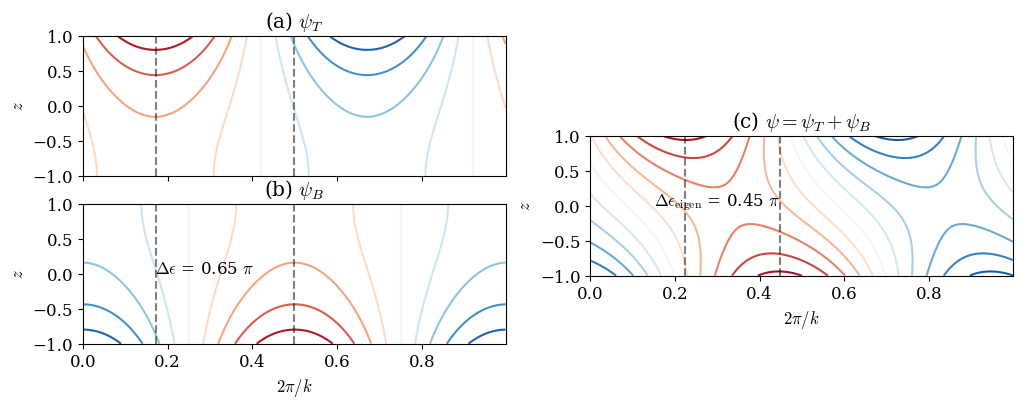

In [22]:
# demonstration of superposition of edge waves

k = k_max[delta_zero_ind]

deps, gamma = get_root(dF, k, delta_vec[delta_zero_ind], guess_init=[0.25*np.pi, 0.25*np.pi], l=0.5)

z_vec = np.linspace(-1, 1, 31)
x_vec = np.linspace(0, 2.0 * np.pi / k, 501, endpoint=False)

Bu, l = 1.0, 0.5
mu = Bu * np.sqrt(k**2 + l**2)

# by default set B = 1 and eps_B = 0, so T = tan(gamma) and eps_T = deps (note the shift in pi)
T = np.tan(gamma)
deps -= np.pi

psi_T = np.zeros((len(z_vec), len(x_vec)))
psi_B = np.zeros((len(z_vec), len(x_vec)))

for i in range(len(z_vec)):
        psi_T[i, :] = np.real(1.0 / (mu * np.sinh(2.0 * mu)) * np.exp(zi * k * x_vec) *
                              (T * np.exp(zi * deps) * np.cosh(mu * (1.0 + z_vec[i]))
                              )
                              )
        psi_B[i, :] = np.real(1.0 / (mu * np.sinh(2.0 * mu)) * np.exp(zi * k * x_vec) *
                              (-                       np.cosh(mu * (1.0 - z_vec[i]))
                              )
                              )
        
##

fig = plt.figure(figsize=(12, 4))

x_loc_l = x_vec[np.where(psi_T[-1, :] == np.max(psi_T[-1, :]))[0][0]] / (2.0 * np.pi / k)
x_loc_r = x_vec[np.where(psi_B[0, :] == np.max(psi_B[0, :]))[0][0]] / (2.0 * np.pi / k)
ax = plt.subplot(2, 2, 1)
ax.contour(x_vec / (2.0 * np.pi / k), z_vec, psi_T, 10)
ax.plot([x_loc_l, x_loc_l], [-1, 1], 'k--', alpha=0.5)
ax.plot([x_loc_r, x_loc_r], [-1, 1], 'k--', alpha=0.5)
ax.set_xticklabels([])
ax.set_ylabel(r"$z$")
ax.set_title(r"(a) $\psi_T$")

ax = plt.subplot(2, 2, 3)
ax.contour(x_vec / (2.0 * np.pi / k), z_vec, psi_B, 10)
ax.plot([x_loc_l, x_loc_l], [-1, 1], 'k--', alpha=0.5)
ax.plot([x_loc_r, x_loc_r], [-1, 1], 'k--', alpha=0.5)
ax.set_xlabel(r"$2\pi/k$")
ax.set_ylabel(r"$z$")
ax.set_title(r"(b) $\psi_B$")

x_diff = 2.0 * (x_loc_r - x_loc_l)
ax.text(0.17, 0.0, r"$\Delta\epsilon$ = %.2f $\pi$" % x_diff)

## combination

field = psi_T + psi_B

x_loc_l = x_vec[np.where(field[-1, :] == np.max(field[-1, :]))[0][0]] / (2.0 * np.pi / k)
x_loc_r = x_vec[np.where(field[0, :] == np.max(field[0, :]))[0][0]] / (2.0 * np.pi / k)
x_diff = 2.0 * (x_loc_r - x_loc_l)

ax = plt.subplot(2, 2, 2)
ax.contour(x_vec / (2.0 * np.pi / k), z_vec, psi_T + psi_B, 10)
ax.plot([x_loc_l, x_loc_l], [-1, 1], 'k--', alpha=0.5)
ax.plot([x_loc_r, x_loc_r], [-1, 1], 'k--', alpha=0.5)
ax.set_xlabel(r"$2\pi/k$")
ax.set_ylabel(r"$z$")
ax.set_title(r"(c) $\psi = \psi_T + \psi_B$")

ax.text(0.15, 0.0, r"$\Delta\epsilon_{\rm eigen}$ = %.2f $\pi$" % x_diff)

# shift the last axes
box = ax.get_position()
box.y0 -= 0.25
box.y1 -= 0.25
ax.set_position(box)

# plt.savefig("./edge_vs_eigen_shift_l05.pdf", bbox_inches="tight")

### GEOMETRIC

/tmp/ipykernel_852406/715579869.py:107: RuntimeWarning: invalid value encountered in divide
  gamma_b = 0.5 * np.sqrt((R**2 + S**2) / (K * P))
/tmp/ipykernel_852406/715579869.py:109: RuntimeWarning: invalid value encountered in divide
  phi_b = 0.5 * np.arcsin( S / np.sqrt(R**2 + S**2))
/tmp/ipykernel_852406/715579869.py:114: RuntimeWarning: divide by zero encountered in divide
  phi_t = 0.5 * np.arctan2(gamma_b, 1.0 / np.tan(2.0 * lam))  # to avoid branch jump


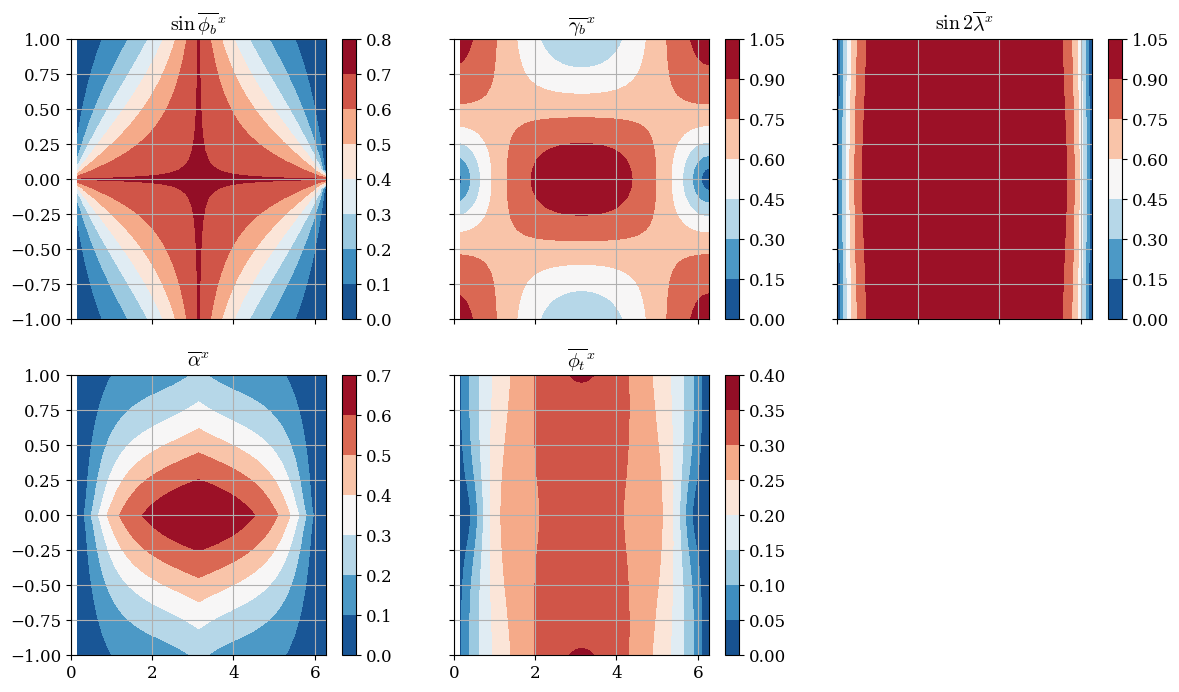

In [23]:
# delta = 0 case

k = k_max[delta_zero_ind]
l = 0.5
delta = 0.0

x_vec = np.linspace(0, 2.0 * np.pi / k, 51, endpoint=False)  # otherwise averages are not zero
y_vec = np.linspace(0, 2.0 * np.pi, 41)  # y domain extent is FIXED (so l = 0.5 is the gravest mode)
z_vec = np.linspace(-1, 1, 31)

GEOM_raw, GEOM_proc = compute_geometric_3d_full(z_vec, y_vec, x_vec, k, delta, l=l, Bu=1.0)

fig = plt.figure(figsize=(14, 8))

ax = plt.subplot(2, 3, 1)
plt.contourf(y_vec, z_vec, np.sin(GEOM_proc["phi_b"][0, :, :]*np.pi))
ax.set_title(r"$\sin\overline{\phi_b}^x$")
ax.set_xticklabels([])
plt.colorbar()
ax.grid()

ax = plt.subplot(2, 3, 2)
plt.contourf(y_vec, z_vec, GEOM_proc["gamma_b"][0, :, :])
ax.set_title(r"$\overline{\gamma_b}^x$")
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar()
ax.grid()

ax = plt.subplot(2, 3, 3)
plt.contourf(y_vec, z_vec, np.sin(2.0*GEOM_proc["lam"][0, :, :]*np.pi))
ax.set_title(r"$\sin2\overline{\lambda}^x$")
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar()
ax.grid()

ax = plt.subplot(2, 3, 4)
plt.contourf(y_vec, z_vec, GEOM_proc["alpha"][0, :, :])
ax.set_title(r"$\overline{\alpha}^x$")
plt.colorbar()
ax.grid()

ax = plt.subplot(2, 3, 5)
plt.contourf(y_vec, z_vec, GEOM_proc["phi_t"][0, :, :])
ax.set_title(r"$\overline{\phi_t}^x$")
ax.set_yticklabels([])
plt.colorbar()
ax.grid()

/tmp/ipykernel_852406/715579869.py:107: RuntimeWarning: invalid value encountered in divide
  gamma_b = 0.5 * np.sqrt((R**2 + S**2) / (K * P))
/tmp/ipykernel_852406/715579869.py:109: RuntimeWarning: invalid value encountered in divide
  phi_b = 0.5 * np.arcsin( S / np.sqrt(R**2 + S**2))
/tmp/ipykernel_852406/715579869.py:114: RuntimeWarning: divide by zero encountered in divide
  phi_t = 0.5 * np.arctan2(gamma_b, 1.0 / np.tan(2.0 * lam))  # to avoid branch jump


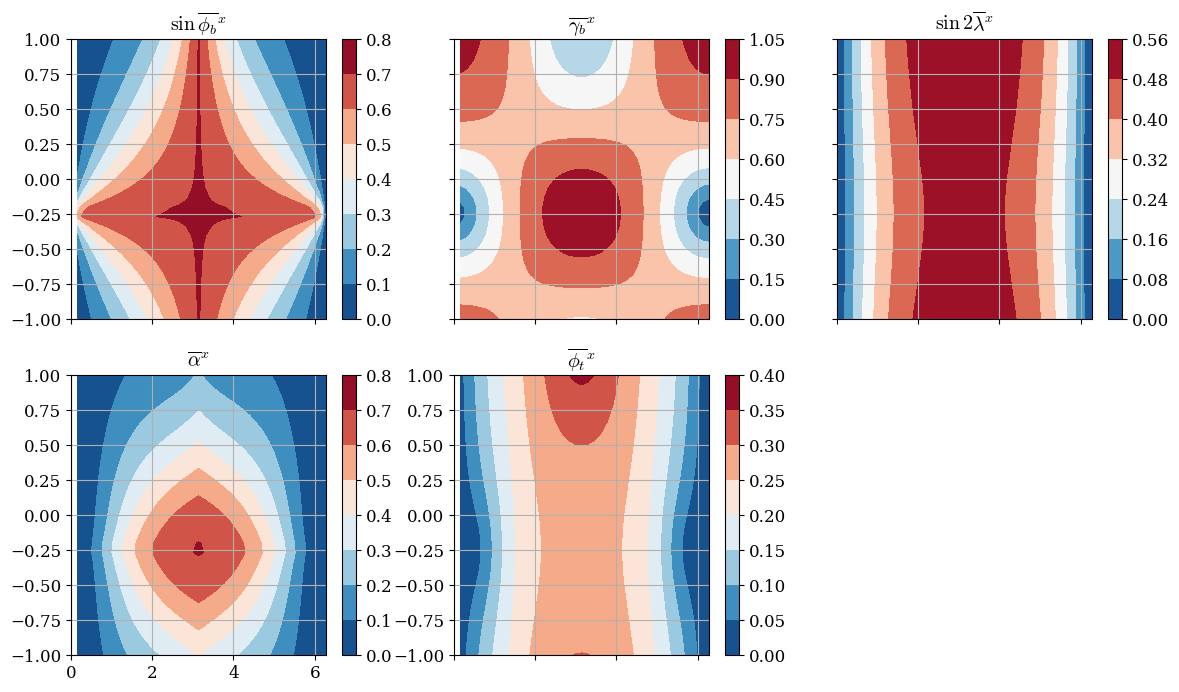

In [24]:
# delta = 0.5 case

k = k_max[delta_pos_ind]
l = 0.5
delta = 0.5

x_vec = np.linspace(0, 2.0 * np.pi / k, 51, endpoint=False)  # otherwise averages are not zero
y_vec = np.linspace(0, 2.0 * np.pi, 41)  # y domain extent is FIXED (so l = 0.5 is the gravest mode)
z_vec = np.linspace(-1, 1, 31)

GEOM_raw, GEOM_proc = compute_geometric_3d_full(z_vec, y_vec, x_vec, k, delta, l=l, Bu=1.0)

fig = plt.figure(figsize=(14, 8))

ax = plt.subplot(2, 3, 1)
plt.contourf(y_vec, z_vec, np.sin(GEOM_proc["phi_b"][0, :, :]*np.pi))
ax.set_title(r"$\sin\overline{\phi_b}^x$")
ax.set_xticklabels([])
plt.colorbar()
ax.grid()

ax = plt.subplot(2, 3, 2)
plt.contourf(y_vec, z_vec, GEOM_proc["gamma_b"][0, :, :])
ax.set_title(r"$\overline{\gamma_b}^x$")
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar()
ax.grid()

ax = plt.subplot(2, 3, 3)
plt.contourf(y_vec, z_vec, np.sin(2.0*GEOM_proc["lam"][0, :, :]))
ax.set_title(r"$\sin2\overline{\lambda}^x$")
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar()
ax.grid()

ax = plt.subplot(2, 3, 4)
plt.contourf(y_vec, z_vec, GEOM_proc["alpha"][0, :, :])
ax.set_title(r"$\overline{\alpha}^x$")
plt.colorbar()
ax.grid()

ax = plt.subplot(2, 3, 5)
plt.contourf(y_vec, z_vec, GEOM_proc["phi_t"][0, :, :])
ax.set_title(r"$\overline{\phi_t}^x$")
ax.set_xticklabels([])
plt.colorbar()
ax.grid()

/tmp/ipykernel_852406/715579869.py:107: RuntimeWarning: invalid value encountered in divide
  gamma_b = 0.5 * np.sqrt((R**2 + S**2) / (K * P))
/tmp/ipykernel_852406/715579869.py:109: RuntimeWarning: invalid value encountered in divide
  phi_b = 0.5 * np.arcsin( S / np.sqrt(R**2 + S**2))
/tmp/ipykernel_852406/715579869.py:114: RuntimeWarning: divide by zero encountered in divide
  phi_t = 0.5 * np.arctan2(gamma_b, 1.0 / np.tan(2.0 * lam))  # to avoid branch jump


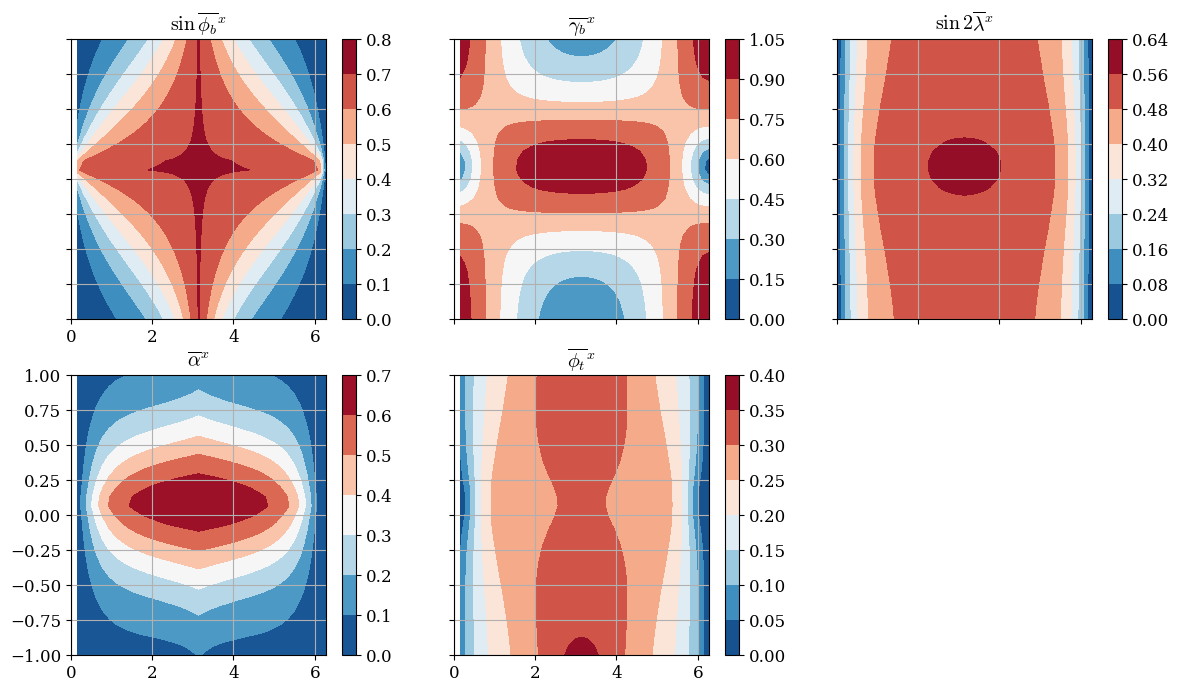

In [25]:
# delta = -0.5 case

k = k_max[delta_neg_ind]
l = 0.5
delta = -0.5

x_vec = np.linspace(0, 2.0 * np.pi / k, 51, endpoint=False)  # otherwise averages are not zero
y_vec = np.linspace(0, 2.0 * np.pi, 41)  # y domain extent is FIXED (so l = 0.5 is the gravest mode)
z_vec = np.linspace(-1, 1, 31)

GEOM_raw, GEOM_proc = compute_geometric_3d_full(z_vec, y_vec, x_vec, k, delta, l=l, Bu=1.0)

fig = plt.figure(figsize=(14, 8))

ax = plt.subplot(2, 3, 1)
plt.contourf(y_vec, z_vec, np.sin(GEOM_proc["phi_b"][0, :, :]*np.pi))
ax.set_title(r"$\sin\overline{\phi_b}^x$")
ax.set_yticklabels([])
plt.colorbar()
ax.grid()

ax = plt.subplot(2, 3, 2)
plt.contourf(y_vec, z_vec, GEOM_proc["gamma_b"][0, :, :])
ax.set_title(r"$\overline{\gamma_b}^x$")
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar()
ax.grid()

ax = plt.subplot(2, 3, 3)
plt.contourf(y_vec, z_vec, np.sin(2.0*GEOM_proc["lam"][0, :, :]))
ax.set_title(r"$\sin2\overline{\lambda}^x$")
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar()
ax.grid()

ax = plt.subplot(2, 3, 4)
plt.contourf(y_vec, z_vec, GEOM_proc["alpha"][0, :, :])
ax.set_title(r"$\overline{\alpha}^x$")
plt.colorbar()
ax.grid()

ax = plt.subplot(2, 3, 5)
plt.contourf(y_vec, z_vec, GEOM_proc["phi_t"][0, :, :])
ax.set_title(r"$\overline{\phi_t}^x$")
ax.set_yticklabels([])
plt.colorbar()
ax.grid()